# Import Libries

In [1]:
import os
import shutil
import struct
import glob
from importlib import reload

import numpy as np
import pandas as pd
import KiMoPack.plot_func as pf
import lmfit

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import min_function as mf
import min_plot as mp
import min_instrument as mins
import min_math as mm

cwd = os.getcwd()
print(f"\nCurrent Work Directory:\n{cwd}")

filename = "sample_solvent"

Qt was found consider switching to qt mode with %matplotlib qt (more comfortable)
Plot_func version 7.4.0
was imported from path:
 /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/KiMoPack
The current working folder is:
 /Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer

Current Work Directory:
/Users/tm/Downloads/sample_solvent_ar_fsta_330ex_caf2_100uw_it1000ms_depolarizer


# Preprocess

In [ ]:
fps_scan = glob.glob(f"{cwd}/*/*.GUI.csv")
fps_scan.sort()
print(f"{len(fps_scan)} scans were found:")
for fp_scan in fps_scan:
    print(os.path.basename(fp_scan))

# shutil.rmtree("Scans")
os.makedirs(f"{cwd}/Scans", exist_ok=True)

## Process Each Scan

In [ ]:
ls_scan = []
# fps_scan = fps_scan[0:1]
for fp_scan in fps_scan:
    print(f"\nCurrent scan:\n{os.path.basename(fp_scan)}")

    (dir_scan, fn_scan) = os.path.split(fp_scan)
    fn_scan = os.path.basename(fp_scan)
    fn_scan = fn_scan.split(".")
    scan_count = ((fn_scan[1].split("_"))[-1]).lower()
    fn_scan = fn_scan[0] + "_" + scan_count
    # fn_scan = fn_scan.replace("uvvis", "caf2")
    print(f"Modified Filename:\n{fn_scan}")

    # raw data in mOD
    scan_df = pd.read_csv(fp_scan, header=0, index_col=0, na_values="NaN", sep=",")
    scan_df = scan_df * 1000
    scan_df.columns = [float(i) for i in scan_df.columns]
    print(
        f"Raw fs-TA data, \033[1m{len(np.where(scan_df.isna())[0])} NaN point\033[0m:"
    )
    # display(scan_df)
    mp.display_fsta_heatmap(
        scan_df,
        zlimit=[-2, 2, 0.5],
    ).show()
    # mins.writeSXUfs(
    #     scan_df,
    #     f"Scans/{fn_scan}_raw.ufs",
    # )
    # mins.writeFSCsv(
    #     scan_df,
    #     f"Scans/{fn_scan}_raw.csv",
    # )

    # tailor
    wl_range = [330, 750]
    tailored_scan_df = mins.tailor_fsta(scan_df, wl_range)
    tailored_scan_df = scan_df.loc[
        (scan_df.index >= wl_range[0]) & (scan_df.index <= wl_range[1])
    ]
    print(
        f"Tailored raw fs-TA data, \033[1m{len(np.where(tailored_scan_df.isna())[0])} NaN points\033[0m:"
    )
    # display(tailored_scan_df)
    # mp.display_fsta_heatmap(tailored_scan_df, zlimit=[-2, 2, 0.5]).show()
    mins.writeSXUfs(
        tailored_scan_df,
        f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}.ufs",
    )
    # mins.writeFSCsv(
    #     tailored_scan_df,
    #     f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}.csv",
    # )

    # repair NaN
    rpnan_tailored_scan_df = tailored_scan_df.interpolate(
        method="linear", limit_direction="both", axis=0
    )
    print(
        f"Repaired tailored raw fs-TA data, \033[1m{len(np.where(rpnan_tailored_scan_df.isna())[0])} NaN point\033[0m:"
    )
    # display(rpnan_tailored_scan_df)
    # mp.display_fsta_heatmap(rpnan_tailored_scan_df, zlimit=[-2, 2, 0.5]).show()
    mins.writeSXUfs(
        rpnan_tailored_scan_df,
        f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}_rpnan.ufs",
    )
    # mins.writeFSCsv(
    #     tailored_scan_df,
    #     f"Scans/{fn_scan}_{wl_range[0]}{wl_range[1]}_rpnan.csv",
    # )

    # store
    ls_scan.append(rpnan_tailored_scan_df)

## Compare Each Scan with the First Scan


In [ ]:
ref_scan_num = 0
for i in range(1, len(ls_scan)):
    scan_diff = mins.compare_scan_fsta(ls_scan[ref_scan_num], ls_scan[i])
    mp.display_fsta_heatmap(scan_diff, zlimit=[-2, 2, 0.1]).show()
    # mins.writeUFS
    #     scan_diff,
    #     # f"Scans/{filename}_diff{i}{ref_scan_num}.ufs",
    # )

## Reaverage

In [ ]:
average_fsta = mins.reaverage_fsta(ls_scan)
display(average_fsta)
mp.display_fsta_heatmap(average_fsta).show()
mins.writeSXUfs(
    average_fsta,
    f"Scans/{filename}_{wl_range[0]}{wl_range[1]}_rna_rav.ufs",
)

## Subtract the Background

In [ ]:
sub_bg_fsta = mins.subtract_background_fsta(average_fsta, [-100, -2])
# display(sub_bg_fsta)
mp.display_fsta_heatmap(sub_bg_fsta).show()
mins.writeSXUfs(
    sub_bg_fsta,
    f"Scans/{filename}_rna_rav_sbg.ufs",
)
# mins.writeFSCsv(
#     sub_bg_fsta,
#     f"Scans/{filename}_rna_rav_sbg.csv",
# )
# mins.writeCVTsv(
#     sub_bg_fsta,
#     f"Scans/{filename}_rna_rav_sbg.tsv",
# )

# Visualize


In [2]:
sample = f"sample_solvent"

filepath = glob.glob(f"{cwd}/*.ufs")[0]
df_data = mins.load_fsta(filepath)
df_data = mins.load_fsta(filepath)
# df_data = mins.tailor_fsta(df_data, [330, 730], [-2, 3000])
df_data = df_data.iloc[:-1, 2:]
nan = np.where(df_data.isna())
display(nan)
display(df_data)
df_data.to_csv(f"{sample}_fsta_data.csv")

globalmax = df_data.max().max()
globalmin = df_data.min().min()
localmax = mins.tailor_fsta(df_data, [355, 700], [0.2, 8000]).max().max()
localmin = mins.tailor_fsta(df_data, [355, 700], [0.2, 8000]).min().min()
print(f"globalmax: {globalmax}")
print(f"globalmin: {globalmin}")
print(f"localmax: {localmax}")
print(f"localmin: {localmin}")

(array([], dtype=int64), array([], dtype=int64))

,-96.505202,-94.505699,-92.505489,-90.506038,-88.504427,-86.505571,-84.504907,-82.503682,-80.503872,-78.504976,...,7099.508161,7199.508202,7299.506588,7399.507076,7499.511266,7599.519599,7699.508205,7799.550962,7899.507232,7999.507887
344.9,0.196374,0.056217,0.161502,0.131552,-0.247817,-0.208985,-0.082086,-0.098319,-0.131728,-0.226293,...,-3.028099,-3.389076,-3.476042,-3.249778,-3.398015,-3.039588,-3.237609,-2.921006,-3.217573,-3.359598
345.7,0.021105,0.067276,0.109839,0.027899,-0.412313,-0.155288,-0.066911,-0.034904,-0.145349,-0.198496,...,-2.935142,-3.277619,-3.395182,-3.179805,-3.468045,-3.019413,-2.891576,-3.088029,-3.089592,-3.201952
346.5,-0.024349,-0.060706,0.057378,0.034995,-0.222122,-0.264568,-0.040614,0.146365,-0.121626,-0.104478,...,-2.965229,-3.242920,-3.126265,-2.900596,-3.416765,-2.982771,-2.818346,-2.836678,-3.321772,-2.959952
347.3,0.034142,0.077663,0.178215,0.030462,-0.308370,-0.222511,-0.009801,0.128427,-0.083043,-0.241829,...,-2.971144,-3.097390,-3.108528,-2.934463,-3.212185,-2.630154,-2.975136,-2.670746,-2.672078,-2.996582
348.1,0.037476,0.019497,0.082380,0.104399,-0.194578,-0.066128,-0.123825,-0.060965,-0.175066,-0.181417,...,-2.526574,-2.891858,-2.734405,-2.469205,-2.762639,-2.299013,-2.504554,-2.458784,-2.479754,-2.478430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646.0,-0.015578,0.158357,0.280121,-0.269573,-0.294337,0.300752,0.007855,0.062769,0.221338,-0.262008,...,0.381293,0.800931,0.616986,0.354525,0.760688,0.544752,0.651589,0.424757,0.449880,0.453891
646.8,-0.129503,0.052860,0.380852,-0.216883,-0.190216,0.238176,0.025334,-0.053031,0.221541,-0.176276,...,0.353999,0.756911,0.655913,0.727327,0.756598,0.424778,0.782184,0.527239,0.540855,0.451657
647.6,-0.105102,0.116052,0.348677,-0.203208,-0.338272,0.047565,0.130323,0.025127,0.227232,-0.295214,...,0.227060,0.657706,0.459267,0.354970,0.694501,0.452288,0.656068,0.611940,0.524212,0.495682
648.3,-0.062467,0.096393,0.315508,-0.252481,-0.165154,0.197608,0.026409,0.107986,0.214526,-0.285013,...,0.266073,0.871347,0.580785,0.456953,0.681783,0.260099,0.647203,0.568182,0.575639,0.431463


globalmax: 12.2882233
globalmin: -3.7770349
localmax: 10.0924153
localmin: -0.1357486


## 2D Map


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


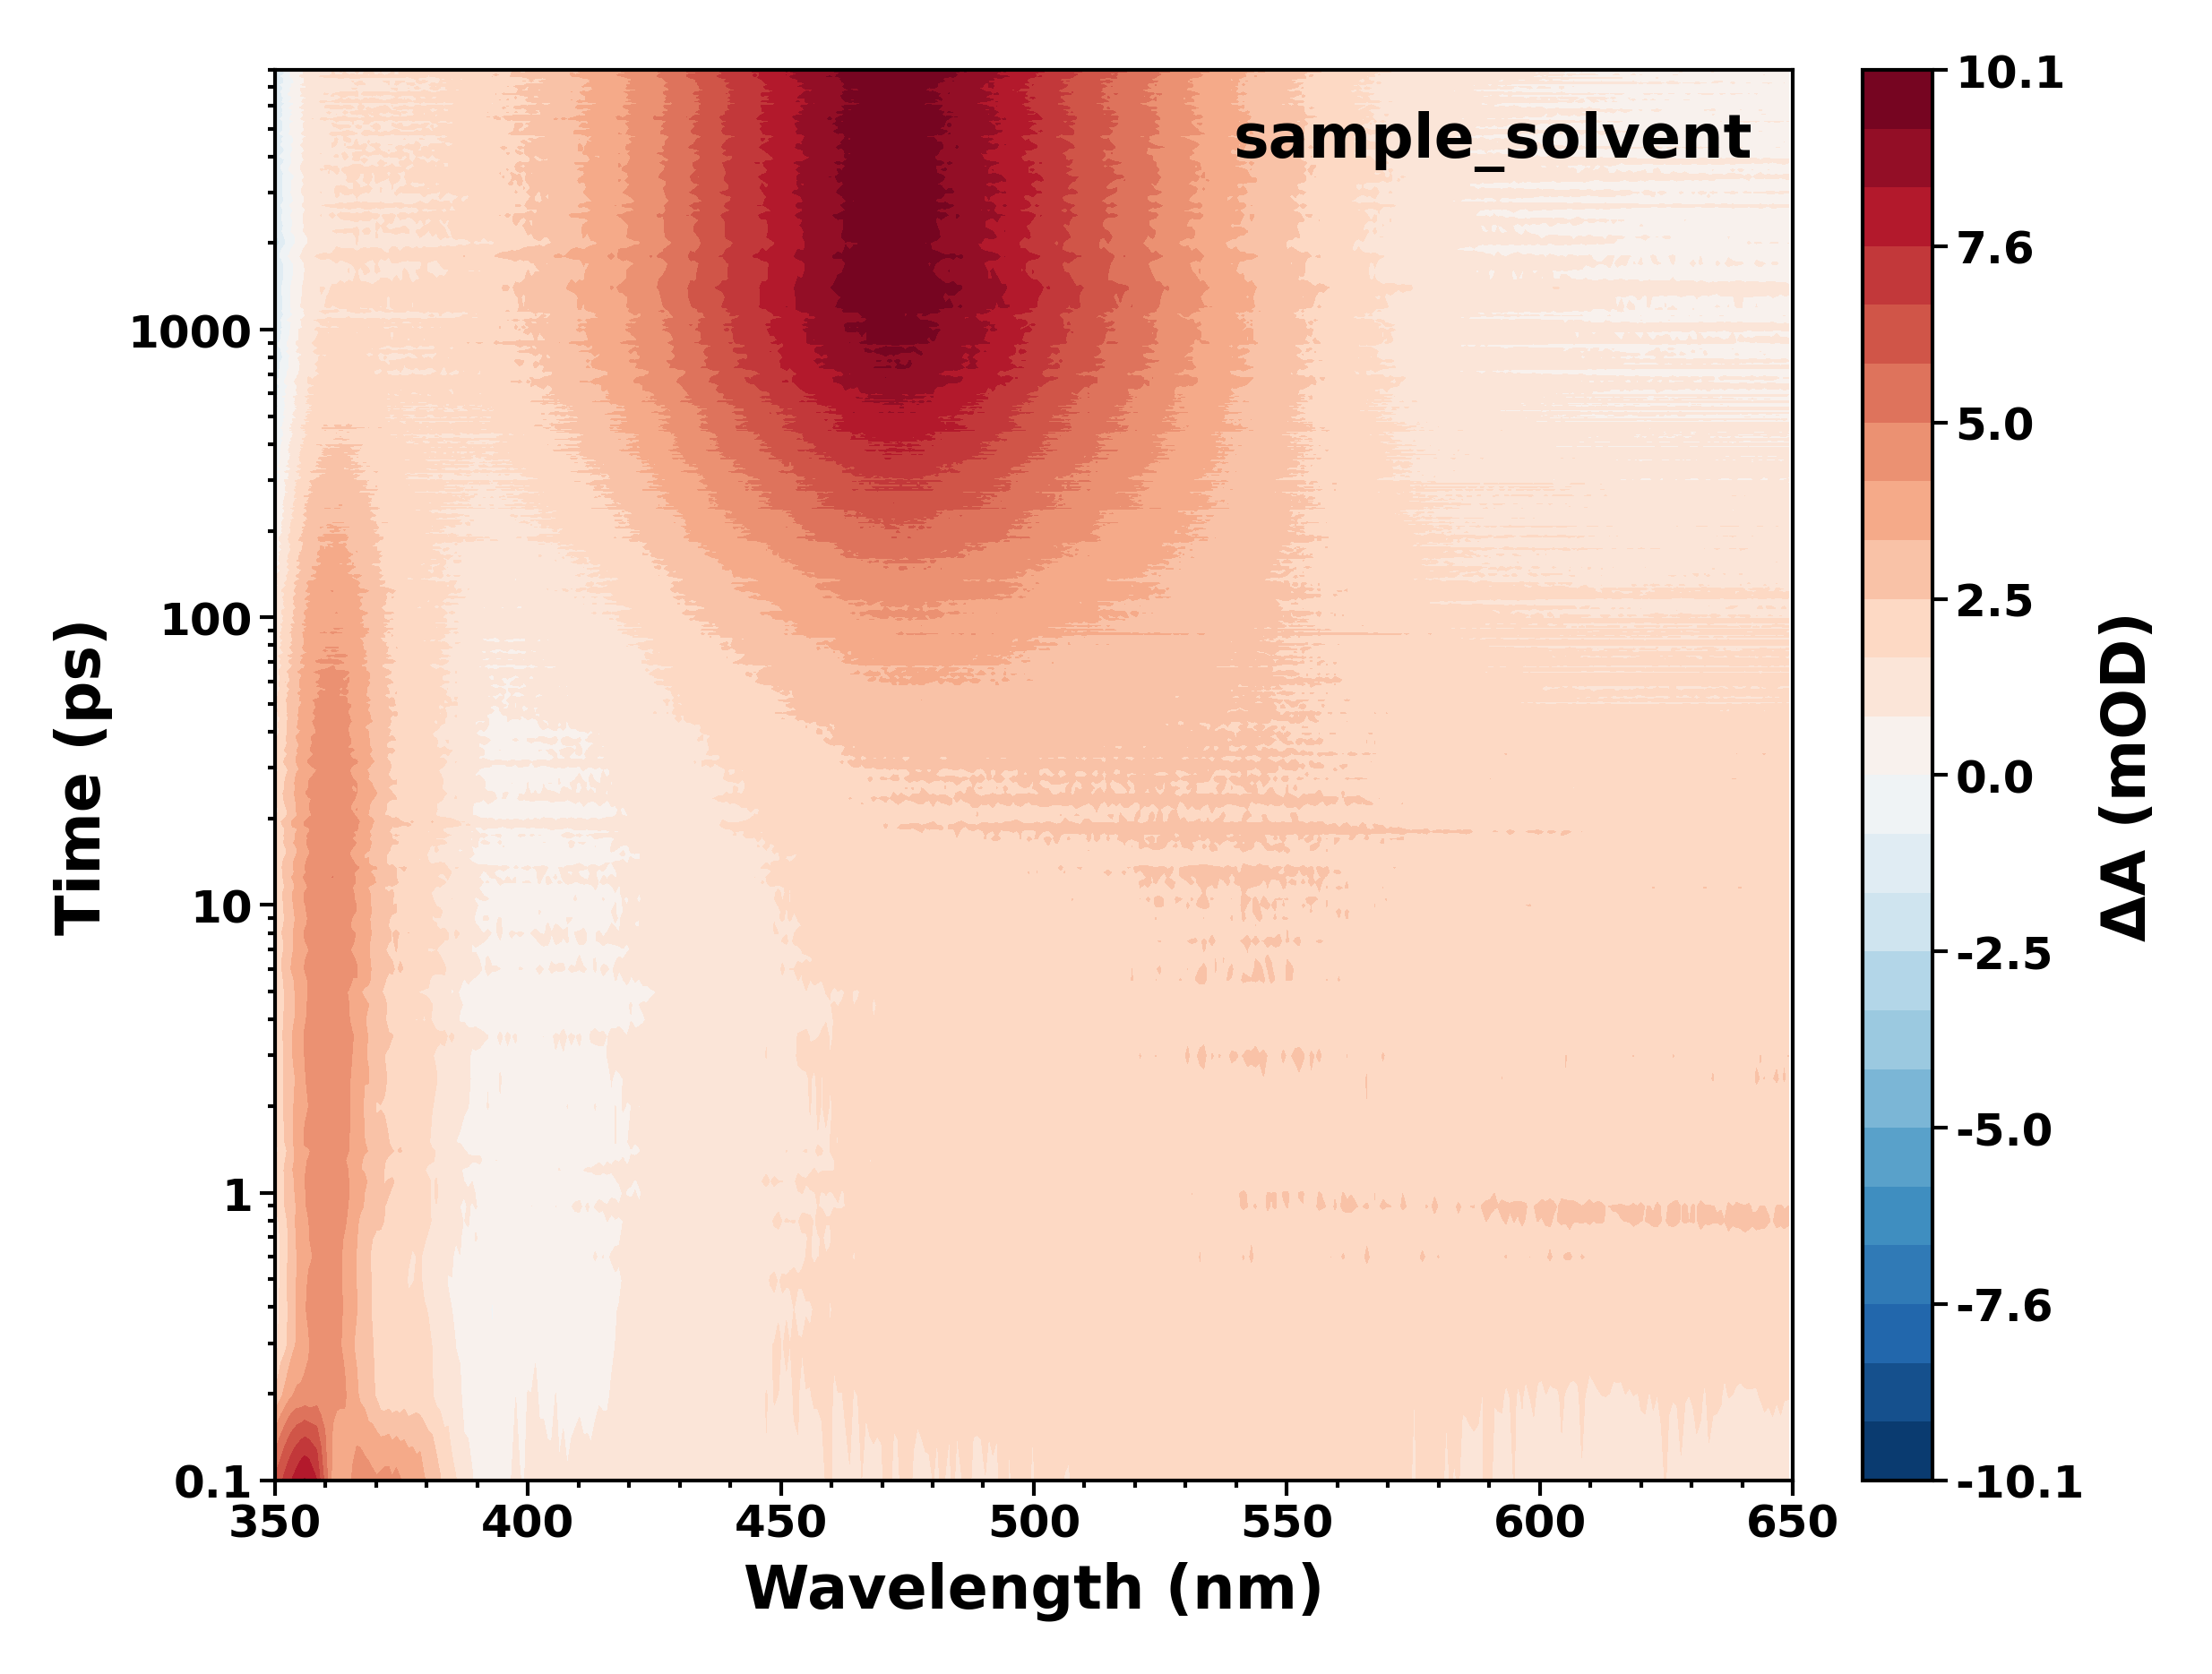

In [4]:
reload(mp)
# mp.display_fsta_heatmap_linear(df_data).show()
# mp.display_fsta_heatmap_log_v2(data, ylimit=[[np.log10(0.5), np.log10(
# 7000)], 1, 0.1]).show()

nm_limit = [[350, 650], 50, 10]
t_limit = [[-0.2, 1, 8000], 0.5, 0.1]
od_limit = [[-localmax, localmax], 1, 0.2]

fig_contour = mp.display_fsta_contourf_log(
    df_fsta=df_data,
    legendtitle=sample,
    xlimit=nm_limit,
    ylimit=[[0.1, 8000], None, None],
    zlimit=od_limit,
)
plt.show()
fig_contour.savefig(f"{sample}_fsta_contour.svg")

# contour_bnm = mp.display_fsta_contourf_symlog(
#     df_fsta=data,
#     legendtitle=sample,
#     xlimit=[[330, 660], 50, 10],
#     # xlimit2=nm_limit,
#     ylimit=t_limit,
#     zlimit=od_limit,
# )
# plt.show()

## Spectra


,0.495890,75.492233,199.496207,458.496645,1499.533601,1699.521668,3499.500138,7399.507076
344.9,0.224457,-0.103545,-1.004806,-2.286362,-3.362229,-3.494956,-3.399577,-3.249778
345.7,0.371916,-0.269286,-1.042252,-2.129333,-3.056379,-3.470871,-3.368086,-3.179805
346.5,0.132016,-0.041301,-0.926038,-2.106029,-2.859763,-2.987738,-2.932701,-2.900596
347.3,0.305233,-0.101829,-0.949010,-1.796252,-2.890530,-2.793630,-3.185562,-2.934463
348.1,0.450686,0.120374,-0.513955,-1.640772,-2.496382,-2.591878,-2.688154,-2.469205
...,...,...,...,...,...,...,...,...
646.0,2.336343,1.776028,1.073425,0.973195,0.588793,0.884469,0.679544,0.354525
646.8,2.287190,1.886848,1.243814,1.083467,0.556484,0.860536,0.717538,0.727327
647.6,2.259277,1.982312,1.151126,1.061359,0.519261,0.810312,0.686532,0.354970
648.3,2.378001,1.998361,1.182058,1.022356,0.634149,0.777491,0.748590,0.456953


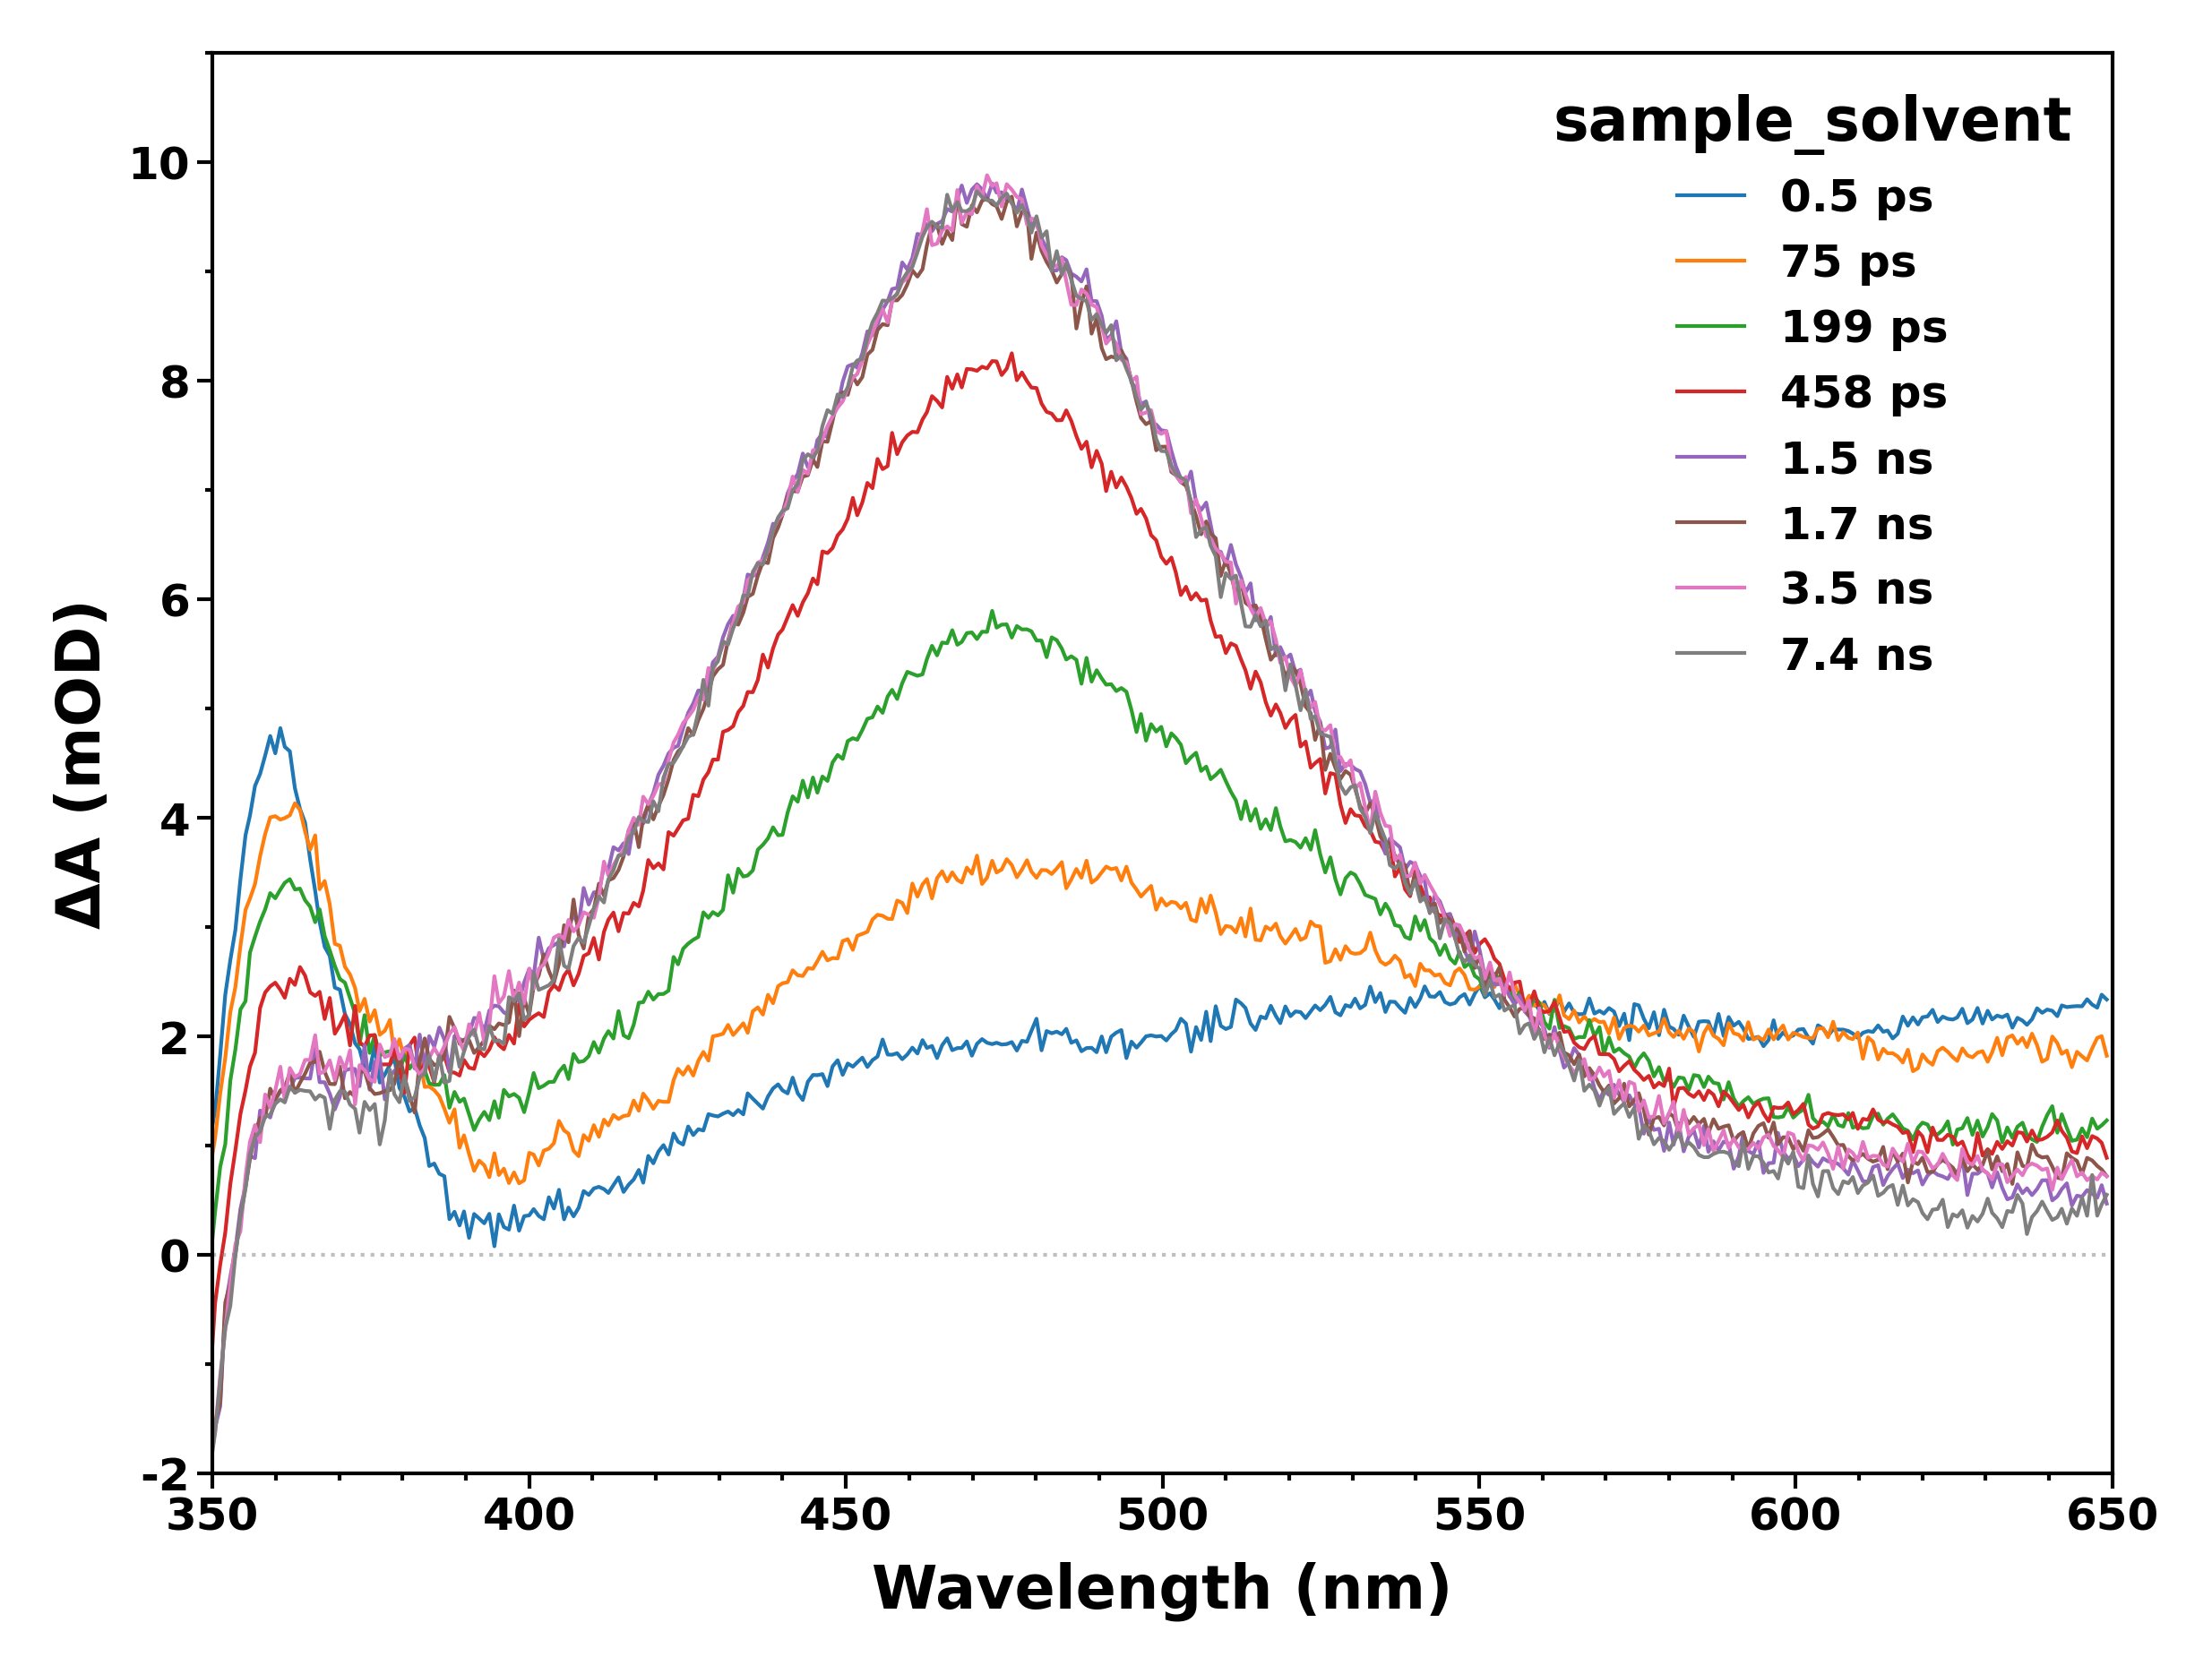

In [5]:
reload(mp)

time_delays = [0.445, 75.3, 200, 457, 1500, 1710, 3490, 7370]
df_spectra = mins.extract_spectra_trspectra(df_data, time_delays)
display(df_spectra)
df_spectra.to_csv(f"{sample}_fsta_spectra.csv", index_label="wl_nm")

fig_fstas = mp.display_fsta_spectra_bnm(
    df_fstas_wl=df_spectra,
    xlimit=nm_limit,
    ylimit=[[-2, 11], 2, 1],
    legendtitle=sample,
    # legendposition="upper left",
    gridon=False,
)
plt.show()
fig_fstas.savefig(f"{sample}_fsta_spectra.svg")

## Kinetics


,356.7,472.3
-96.505202,-0.068185,0.006519
-94.505699,0.043814,-0.048864
-92.505489,0.047107,0.089605
-90.506038,-0.062083,-0.150243
-88.504427,-0.331647,-0.071852
...,...,...
7599.519599,1.490478,9.886132
7699.508205,1.312139,9.931083
7799.550962,1.064344,9.771092
7899.507232,1.248555,9.950995


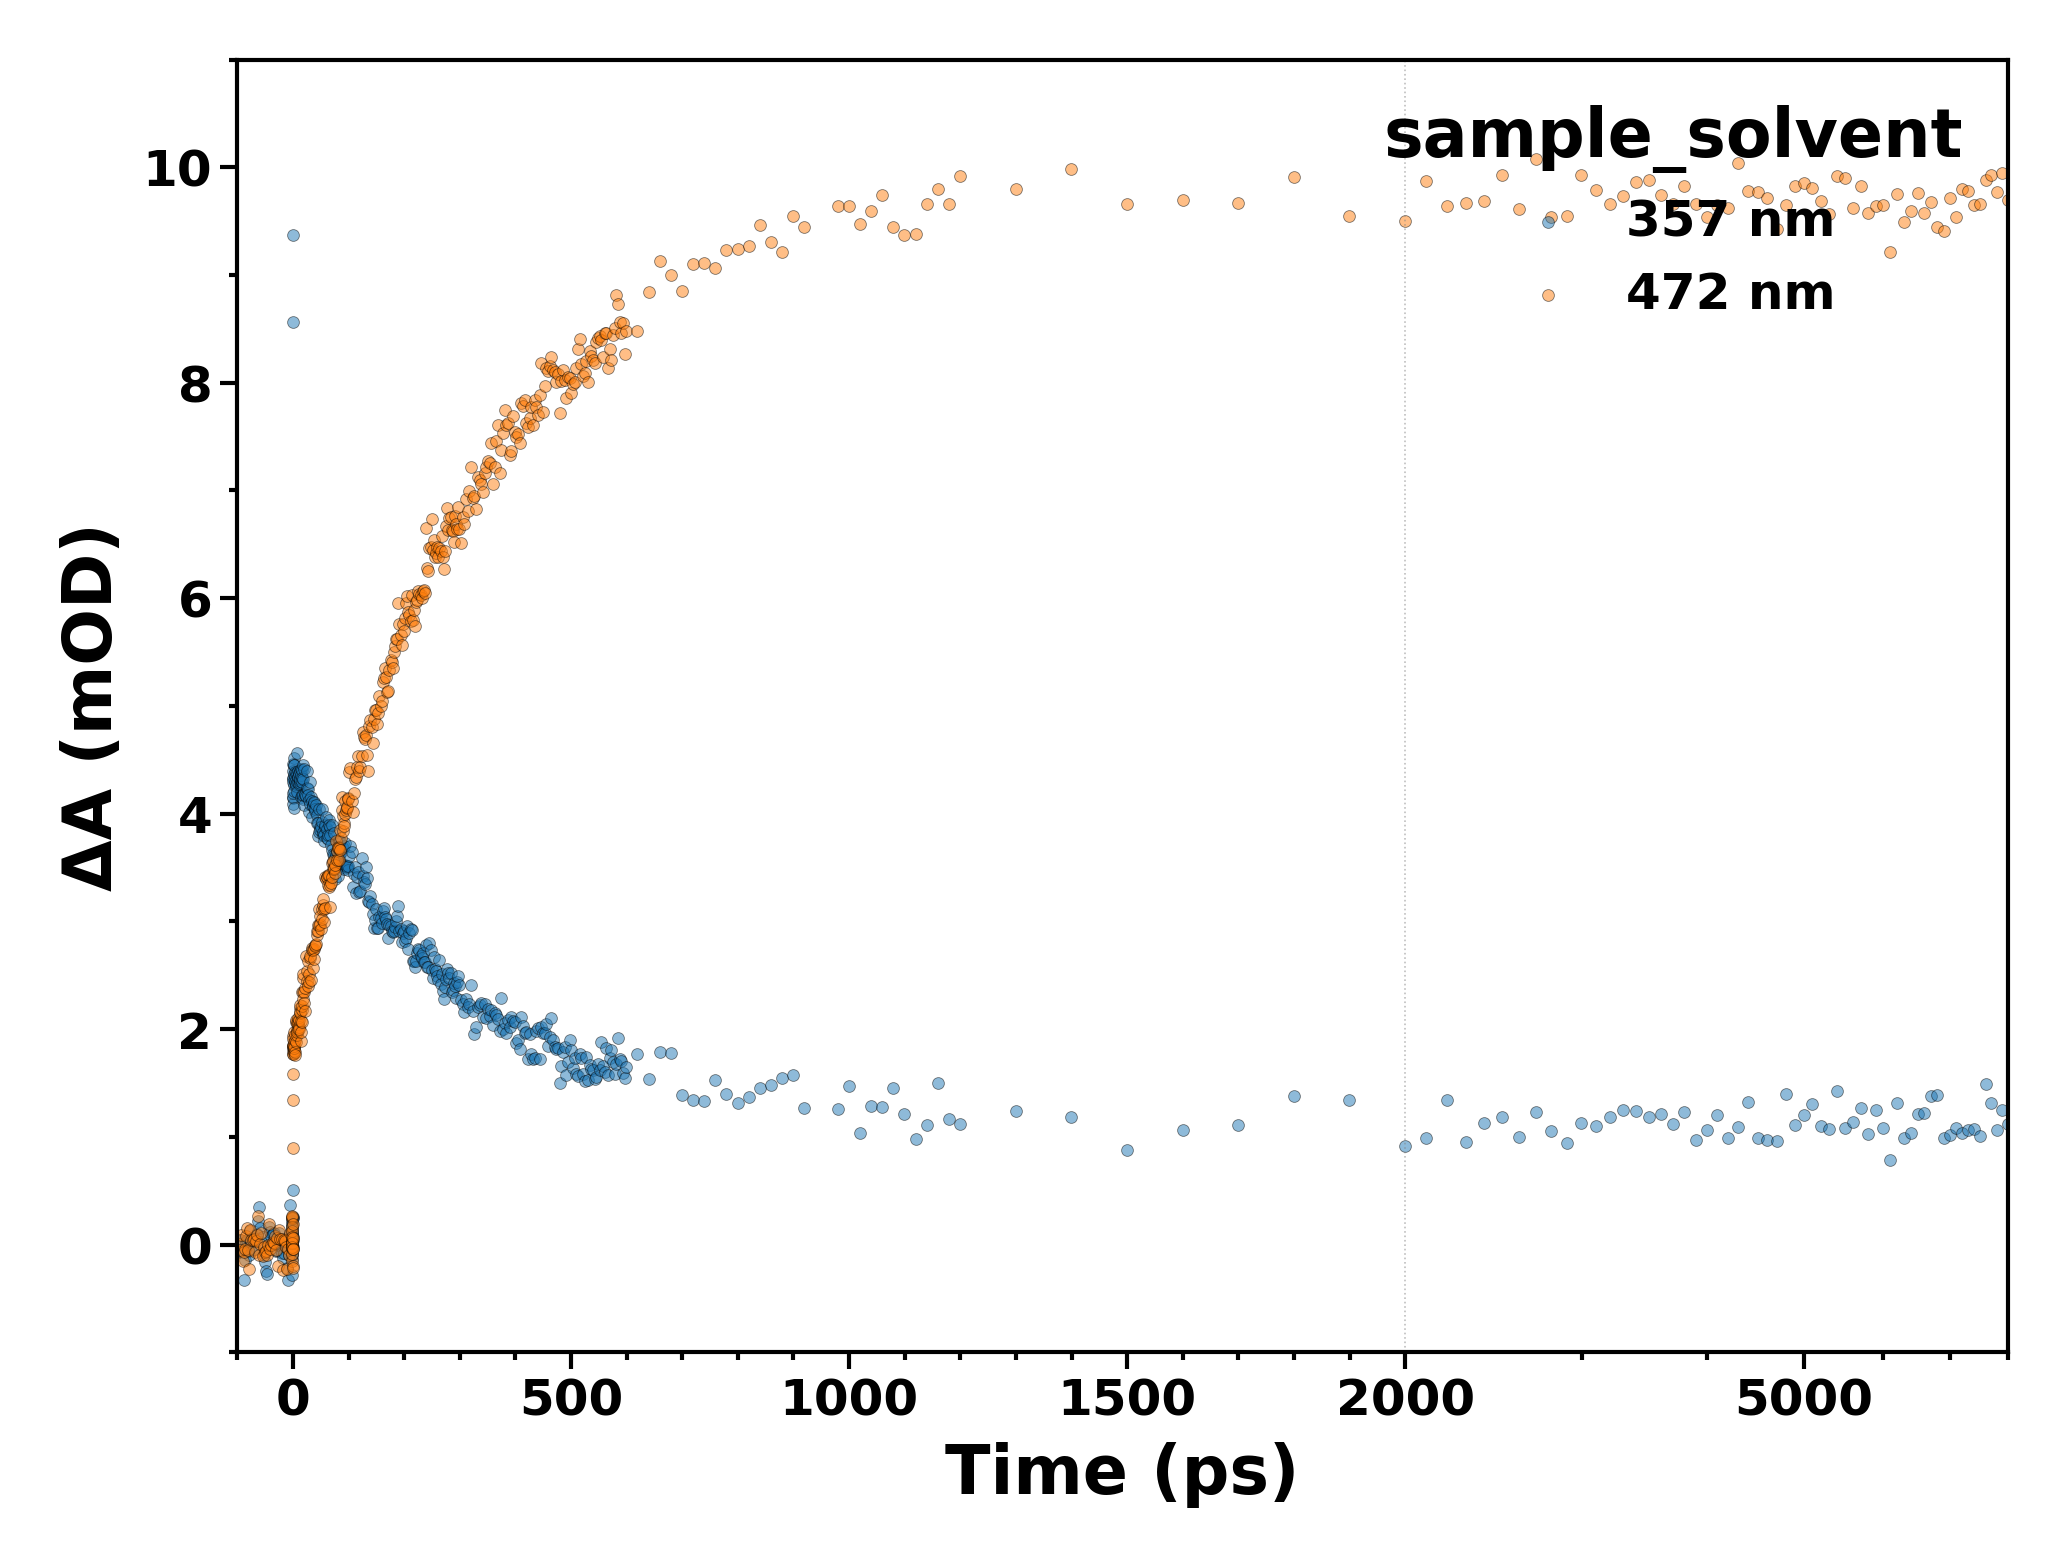

In [6]:
kinetics_t_limit = [[-100, 2000, 8000], 500, 100]
kinetics_od_limit = [[-1, 11], 2, 1]

wavelengths = [357, 472]
df_kinetics = mins.extract_1colkinetics_trspectra(df_data, wavelengths)
display(df_kinetics)
# mp.preview_2coldf(kinetics)
df_kinetics.to_csv(f"{sample}_fsta_kinetics.csv", index=True, index_label="time_ps")

fig_fstak = mp.display_fsta_1colkinetics_symlog(
    df_1col=df_kinetics,
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
)
plt.show()
fig_fstak.savefig(f"{sample}_fsta_kinetics.svg")

# Single wavelength fitting


In [ ]:
func = "GPdfConHDExp"

fits = []
for i in range(int((mf.reshape_1colto2col(df_kinetics)).shape[1] / 2)):
    fit = mm.fit_fsta_2colkinetics(
        data=(mf.reshape_1colto2col(df_kinetics)).iloc[:, [2 * i, 2 * i + 1]],
        func_name=func,
        p0=[0, 0, 0.05, 5, 300, 2, 100000],
        yaxistype="linear",
    )
    fits.append(fit[0])

In [ ]:
fit = mm.fit_fsta_2colkinetics(
    data=df_kinetics.iloc[:, [2, 3]],
    func_name=func,
    p0=[0, 0, 0.05, 0.7, 200, 0.2, 2000],
    # bounds=(
    #     [-0.00001, -2, -1, 0, 295, 0, 0],
    #     [0.00001, 2, 1, np.inf, np.inf, np.inf, np.inf],
    # ),
    yaxistype="linear",
)
# fits.append(fit1[0])

In [ ]:
mp.display_fsta_1colkinetics_fitted_symlog(
    fits,
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
    # legendposition="upper left",
    showwn=True,
)
plt.show()

# Global Analysis


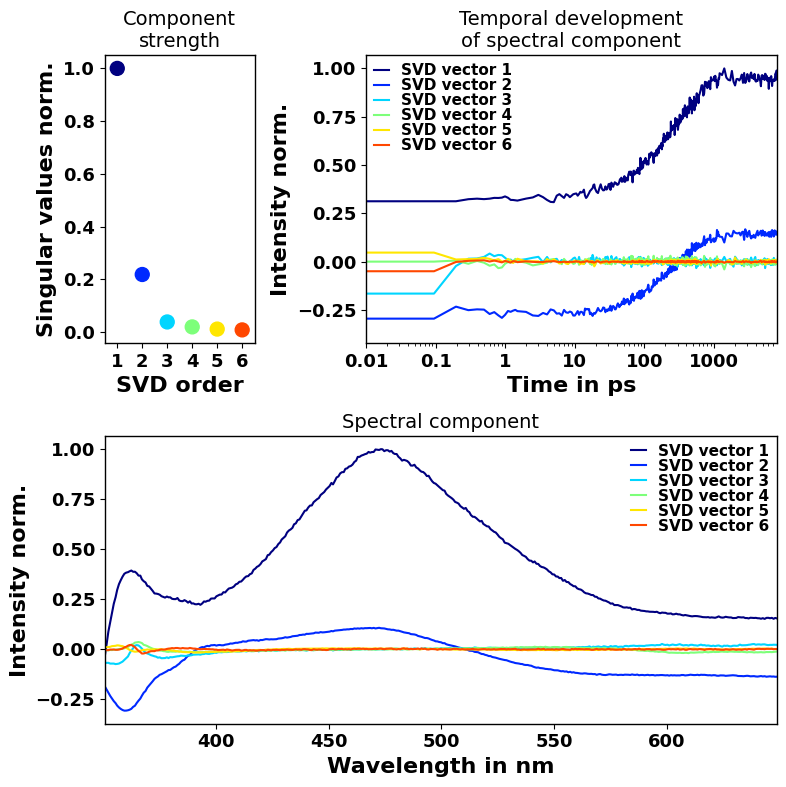

In [7]:
# plt.close("all")

ta = pf.TA(filename=sample, ds=df_data.T, sep=",", transpose=False)
# ta.lintresh = 100

# spectra
ta.wave_nm_bin = None
ta.rel_time = time_delays
# ta.time_width_percent=0
# ta.timelimits = [ylimit[0][0], ylimit[0][2]]
# ta.timelimits = [-30, 500]
# ta.ignore_time_region=[-0.5, 0.5]
ta.bordercut = nm_limit[0]  # wavelength range

# kinetics
ta.wavelength_bin = None
ta.rel_wave = wavelengths
# ta.scattercut=[300, 325]

# DA
ta.cmap = pf.cm.jet
ta.intensity_range = od_limit[0]
# ta.log_scale=False
# display(ta.ds)

# fit
ta.error_matrix_amplification = 10
ta.log_fit = False

# plot
# ta.log_scale=False
ta.Plot_RAW(
    plotting=[3],
    path=cwd,
    # scale_type="symlog"
)
# ta.Plot_Interactive()

## Parallel


### two components

In [ ]:
ta.mod = "paral"  # "exponential"
path = "p2"
# k0: s1 decay
# k1: t1 decay
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 35, vary=True)
ta.par.add("k1", value=1 / 30000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.2, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=filename.replace(".csv", "") + "_" + path,
    sep=",",
)
# ta.Save_Plots(
#              path=os.getcwd()+"/parallelST",
#              savetype="pdf",
#              filename=filename.replace(".csv", "") + "_parallelST",
# )

## Sequential


### two components

Exception in thread Thread-5 (listen):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keyboard/__init__.py", line 294, in listen
    _os_keyboard.listen(self.direct_callback)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keyboard/_darwinkeyboard.py", line 430, in listen
    raise OSError("Error 13 - Must be run as administrator")
OSError: Error 13 - Must be run as administrator



Fit Results:
Model Used: consecutive

The minimum error is:9.16419719e+03
The minimum R2-value is:9.89878240e-01

In Rates

+------------+-------------+--------------+--------+-------+-------+--------+
|            |       value |   init_value | vary   |   min |   max | expr   |
+============+=============+==============+========+=======+=======+========+
| k0         | 0.00331139  |   0.00333333 | True   |     0 |   inf |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| k1         | 6.26166e-14 |   1e-06      | True   |     0 |   inf |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| t0         | 0.0019656   |   0          | True   |    -1 |     1 |        |
+------------+-------------+--------------+--------+-------+-------+--------+
| resolution | 0.25        |   0.25       | False  |     0 |     1 |        |
+------------+-------------+--------------+--------+-------+-------+--------+

The rates conver

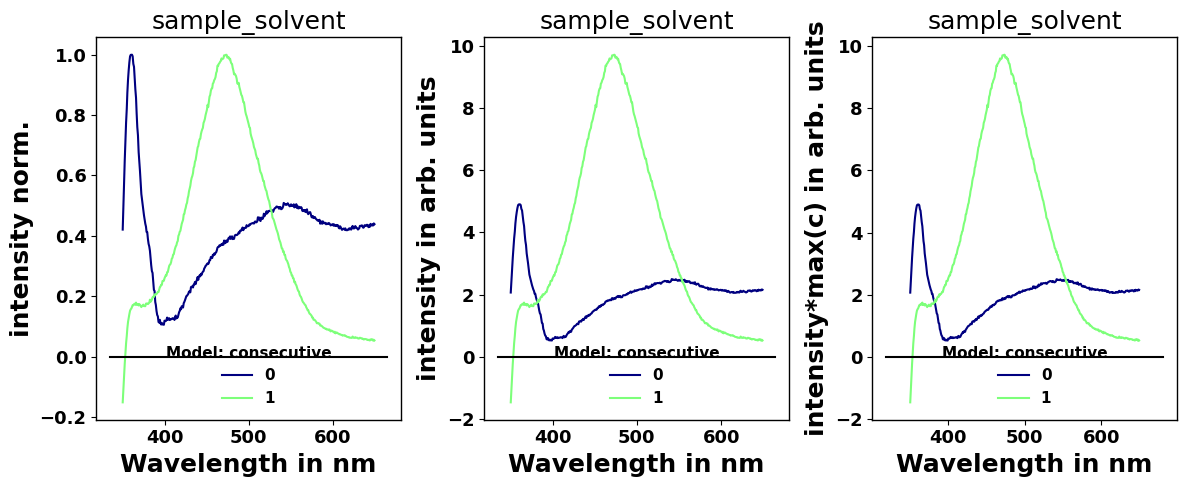

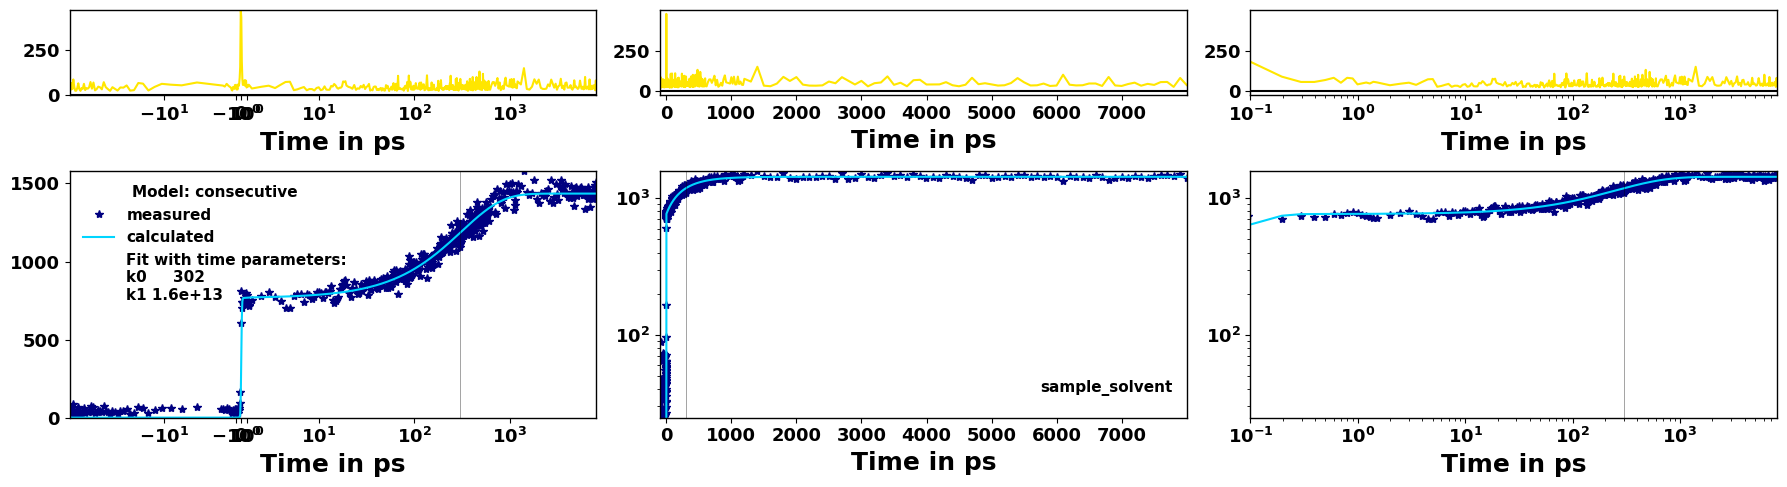

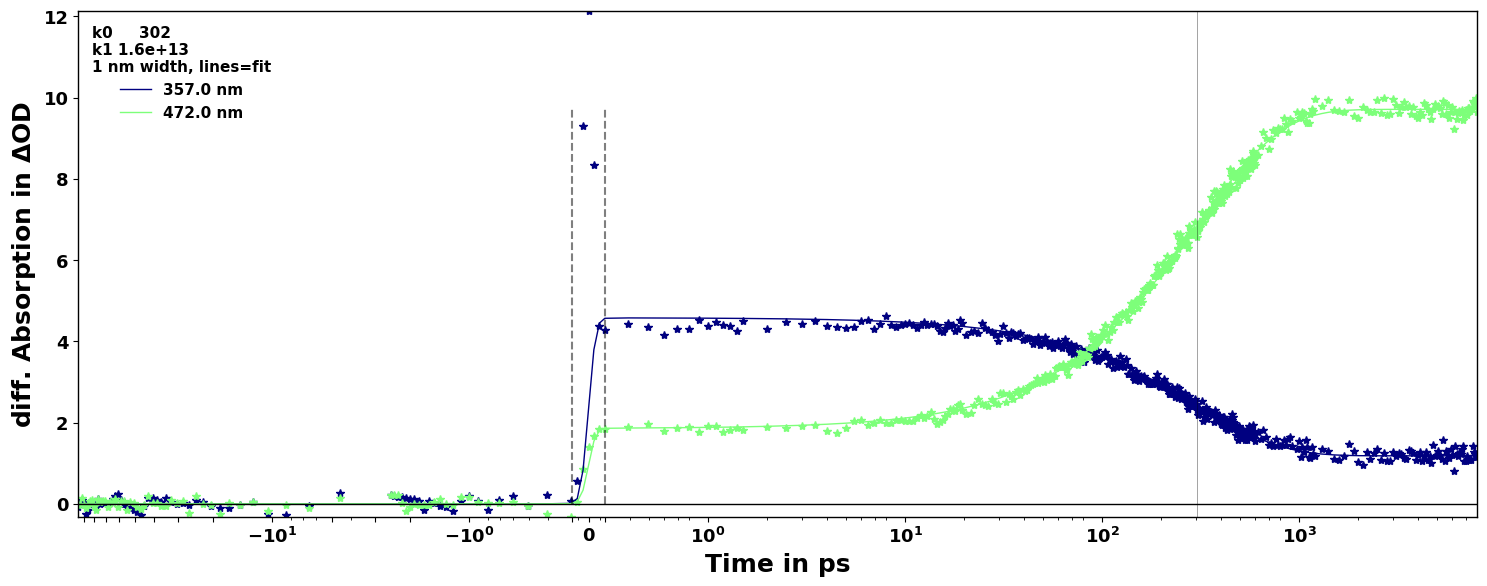

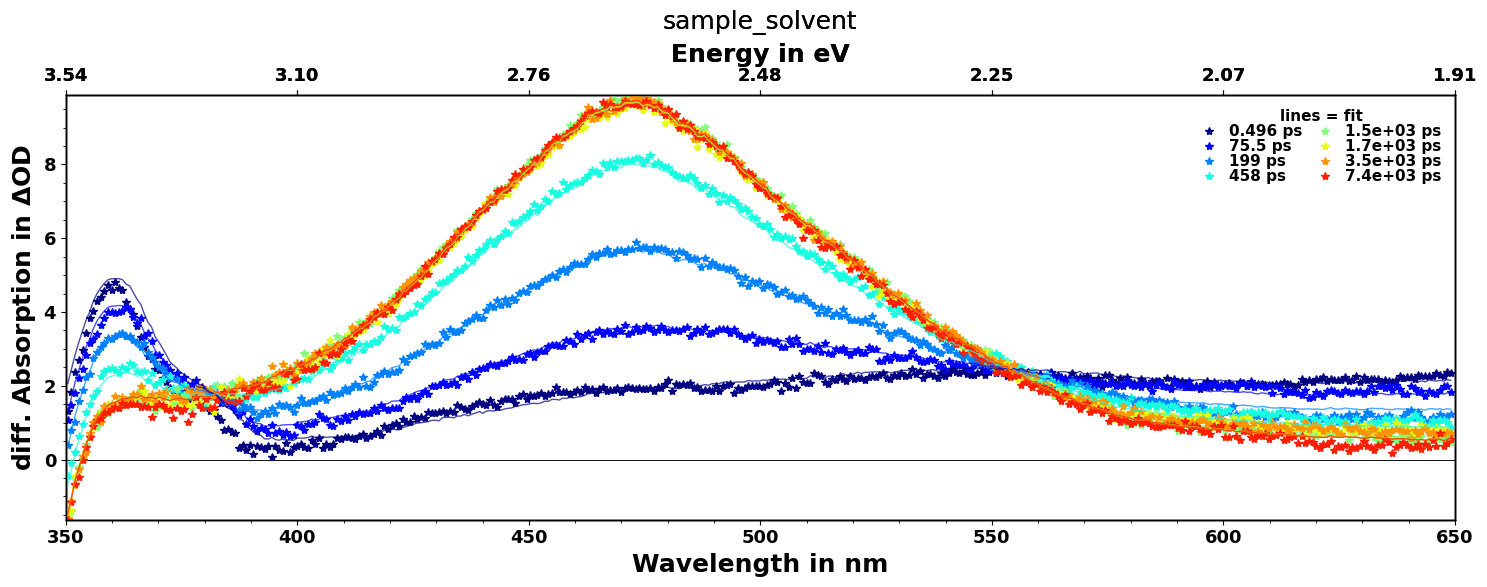

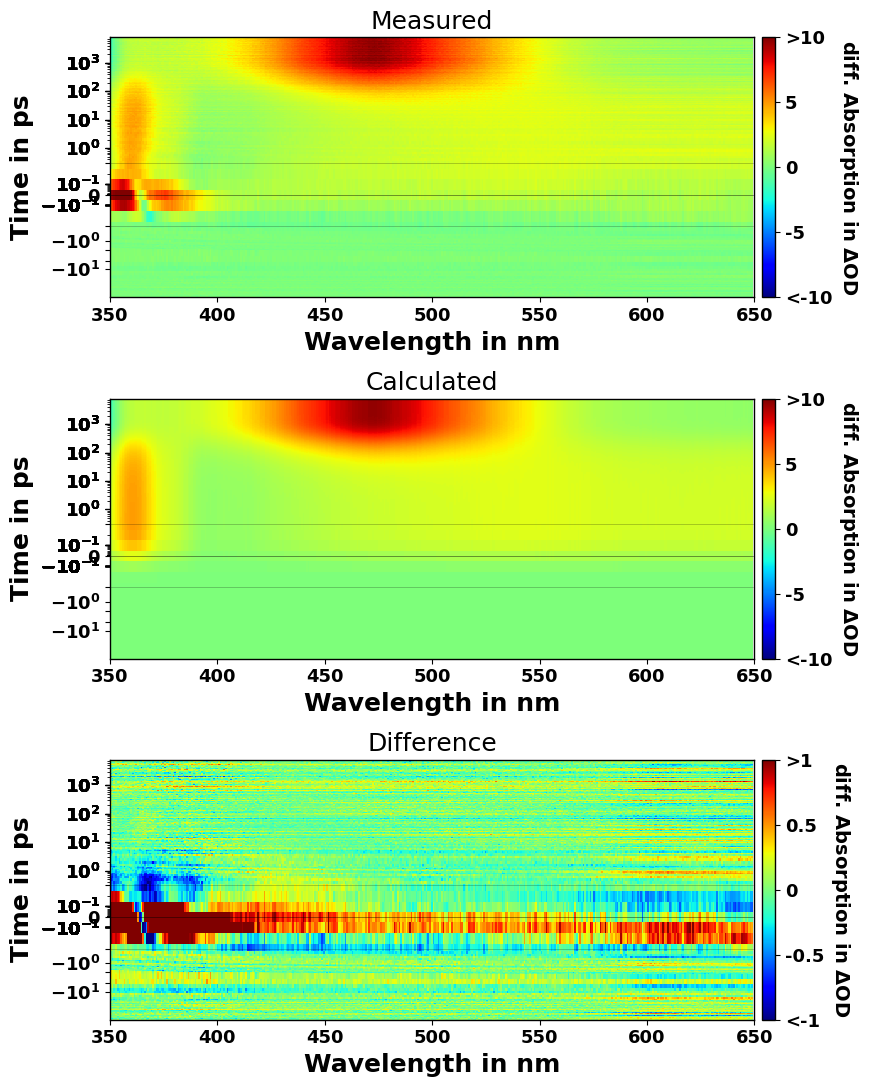

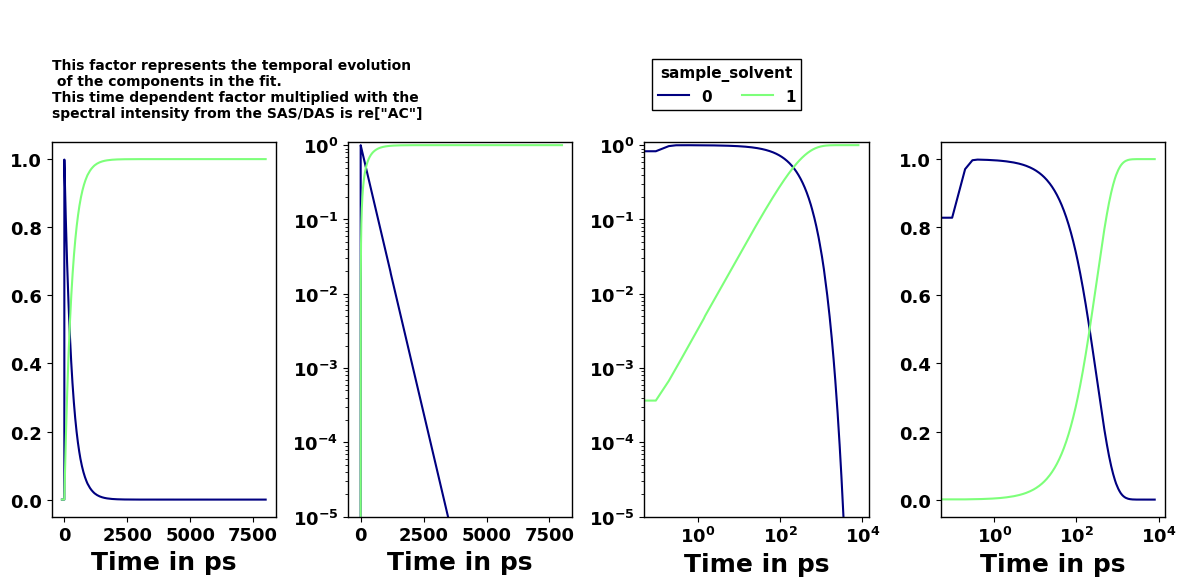

In [8]:
reload(mf)
reload(mp)

ta.mod = "consecutive"
path = "s2"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 300, vary=True)
ta.par.add("k1", value=1 / 1000000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=20)
ta.Plot_fit_output(path=path)

df_fitted_data = ta.re["AC"].T
df_fitted_data.columns.name = None
df_fitted_data.index.name = None
df_fitted_data.to_csv(f"{path}/{sample}_{path}_fitted_fsta_data.csv", sep=",")

df_fitted_spectra = mins.extract_spectra_trspectra(df_fitted_data, time_delays)
df_fitted_spectra = df_fitted_spectra.rename(columns=lambda x: str(x) + "_fit")
df_fitted_spectra.to_csv(
    f"{path}/{sample}_{path}_fitted_fsta_spectra.csv", index_label="wl_nm"
)

df_fitted_kinetics = mins.extract_1colkinetics_trspectra(df_fitted_data, wavelengths)
df_fitted_kinetics = df_fitted_kinetics.rename(columns=lambda x: str(x) + "_fit")
df_fitted_kinetics.to_csv(
    f"{path}/{sample}_{path}_fitted_fsta_kinetics.csv", index_label="time_ps"
)

df_fitted_das = ta.re["DAC"]
df_fitted_das.index.name = "wl_nm"
df_fitted_das.to_csv(f"{path}/{sample}_{path}_fitted_fsta_das.csv", sep=",")

df_fitted_conc = ta.re["c"]
df_fitted_conc.index.name = "time_ps"
df_fitted_conc.to_csv(f"{path}/{sample}_{path}_fitted_fsta_conc.csv", sep=",")

### three components


In [ ]:
reload(mf)
reload(mp)

ta.mod = "consecutive"
path = "s3"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 0.1, vary=True)
ta.par.add("k1", value=1 / 10, vary=True)
ta.par.add("k2", value=1 / 600, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=50)
ta.Plot_fit_output(path=path)

df_fitted_data = ta.re["AC"].T
df_fitted_data.columns.name = None
df_fitted_data.index.name = None
df_fitted_data.to_csv(f"{path}/{sample}_{path}_fitted_fsta_data.csv", sep=",")

df_fitted_spectra = mins.extract_spectra_trspectra(df_fitted_data, time_delays)
df_fitted_spectra = df_fitted_spectra.rename(columns=lambda x: str(x) + "_fit")
df_fitted_spectra.to_csv(
    f"{path}/{sample}_{path}_fitted_fsta_spectra.csv", index_label="wl_nm"
)

df_fitted_kinetics = mins.extract_1colkinetics_trspectra(df_fitted_data, wavelengths)
df_fitted_kinetics = df_fitted_kinetics.rename(columns=lambda x: str(x) + "_fit")
df_fitted_kinetics.to_csv(
    f"{path}/{sample}_{path}_fitted_fsta_kinetics.csv", index_label="time_ps"
)

df_fitted_das = ta.re["DAC"]
df_fitted_das.index.name = "wl_nm"
df_fitted_das.to_csv(f"{path}/{sample}_{path}_fitted_fsta_das.csv", sep=",")

df_fitted_conc = ta.re["c"]
df_fitted_conc.index.name = "time_ps"
df_fitted_conc.to_csv(f"{path}/{sample}_{path}_fitted_fsta_conc.csv", sep=",")

### four components


In [ ]:
reload(mf)
reload(mp)

ta.mod = "consecutive"
path = "s4"
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 0.1, vary=True)
ta.par.add("k1", value=1 / 10, vary=True)
ta.par.add("k2", value=1 / 200, vary=True)
ta.par.add("k3", value=1 / 5000, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.25, min=0, max=1, vary=False)
# ta.par.add("infinite")
# ta.par.add("background")

ta.Fit_Global(fit_chirp=False, sub_sample=20)
ta.Plot_fit_output(path=path)

df_fitted_data = ta.re["AC"].T
df_fitted_data.columns.name = None
df_fitted_data.index.name = None
df_fitted_data.to_csv(f"{path}/{sample}_{path}_fitted_fsta_data.csv", sep=",")

df_fitted_spectra = mins.extract_spectra_trspectra(df_fitted_data, time_delays)
df_fitted_spectra = df_fitted_spectra.rename(columns=lambda x: str(x) + "_fit")
df_fitted_spectra.to_csv(
    f"{path}/{sample}_{path}_fitted_fsta_spectra.csv", index_label="wl_nm"
)

df_fitted_kinetics = mins.extract_1colkinetics_trspectra(df_fitted_data, wavelengths)
df_fitted_kinetics = df_fitted_kinetics.rename(columns=lambda x: str(x) + "_fit")
df_fitted_kinetics.to_csv(
    f"{path}/{sample}_{path}_fitted_fsta_kinetics.csv", index_label="time_ps"
)

df_fitted_das = ta.re["DAC"]
df_fitted_das.index.name = "wl_nm"
df_fitted_das.to_csv(f"{path}/{sample}_{path}_fitted_fsta_das.csv", sep=",")

df_fitted_conc = ta.re["c"]
df_fitted_conc.index.name = "time_ps"
df_fitted_conc.to_csv(f"{path}/{sample}_{path}_fitted_fsta_conc.csv", sep=",")

## Target

### two components


In [ ]:
ta.mod = mm.targetST
path = "t2"
# k0: s1 decay
# k1: ISC
# k2: t1 decay
ta.par = lmfit.Parameters()
ta.par.add("k0", value=1 / 4600, vary=True)
ta.par.add("k1", value=1 / 8, vary=True)
ta.par.add("k2", value=1 / 4600, vary=True)
ta.par.add("t0", value=0, min=-1, max=1, vary=True)
ta.par.add("resolution", value=0.20, min=0, max=1, vary=True)
ta.Fit_Global(fit_chirp=False, sub_sample=10)
ta.Plot_fit_output(path=path)

ta.Save_data(
    save_RAW=False,
    path=path,
    filename=filename.replace(".csv", "") + "_" + path,
    sep=",",
)

## Visualize Global Fitting

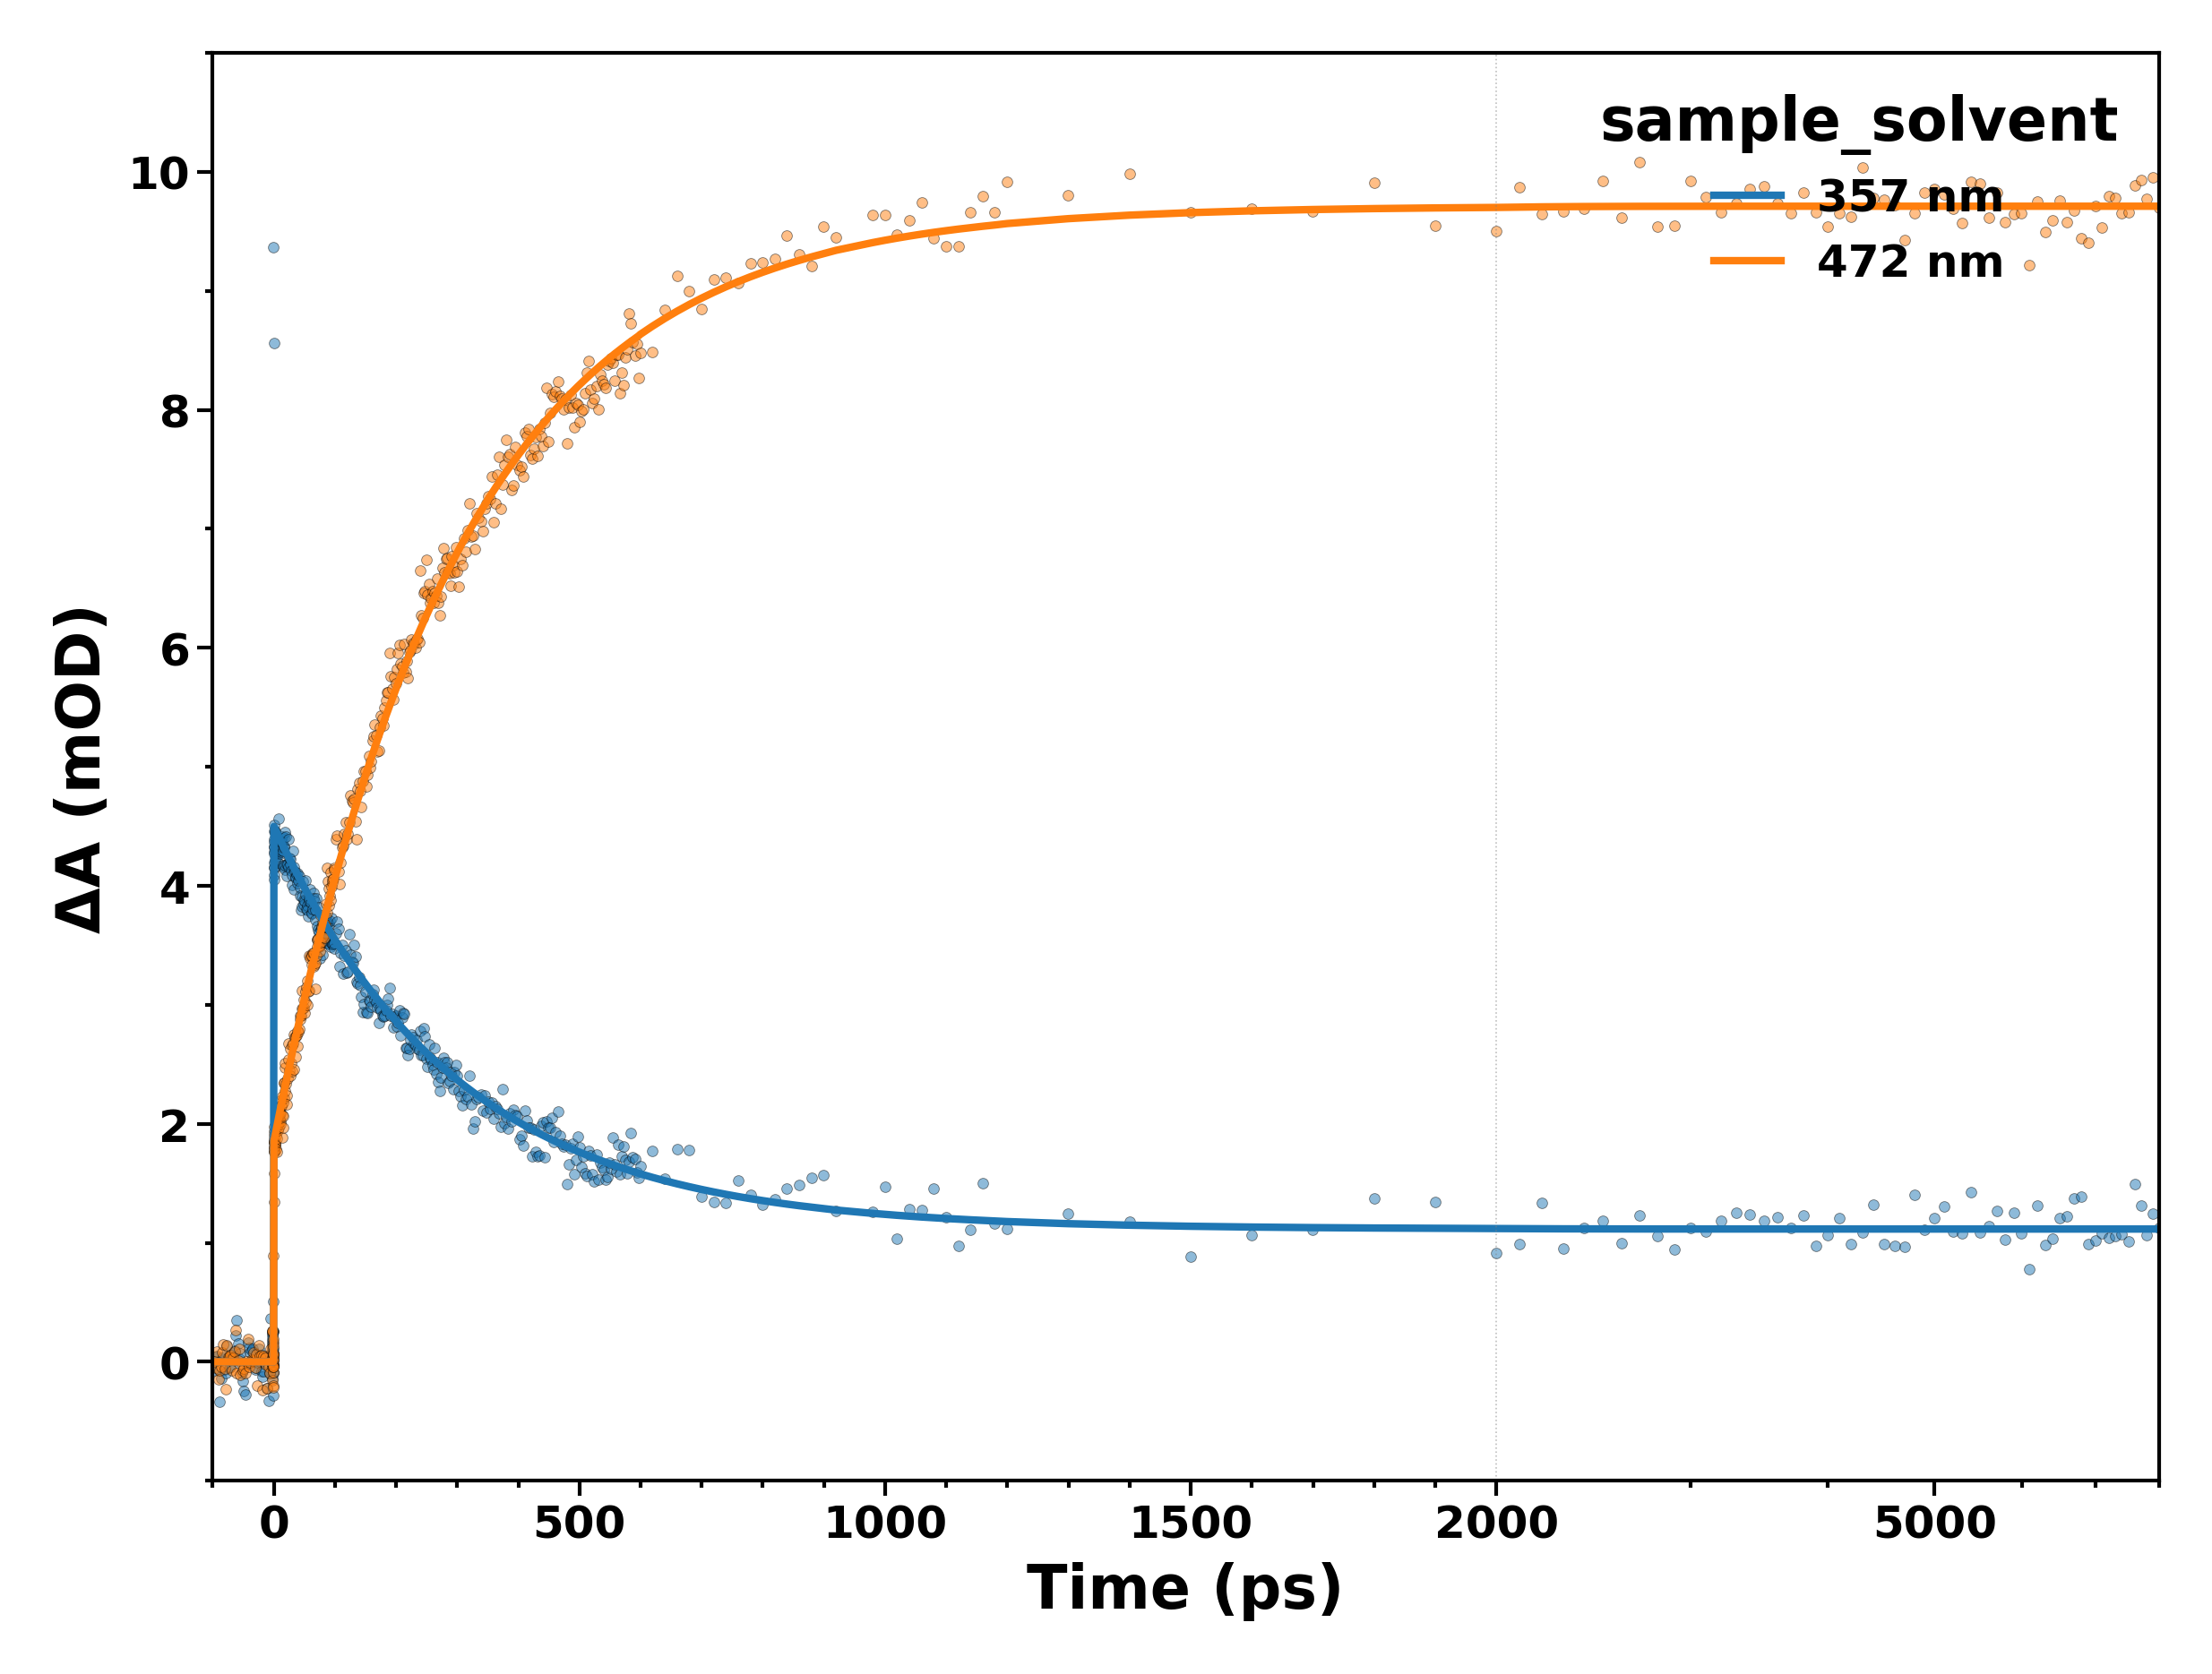

In [9]:
reload(mp)
reload(mf)

folder_fitting_results = "s2"

fp_kinetics = glob.glob(f"*_fsta_kinetics.csv")
df_kinetics = pd.read_csv(fp_kinetics[0], header=0, index_col=0, sep=",")
fp_fitted_kinetics = glob.glob(f"{folder_fitting_results}/*_fitted_fsta_kinetics.csv")
df_fitted_kinetics = pd.read_csv(fp_fitted_kinetics[0], header=0, index_col=0, sep=",")
fig_fitted_kinetics = mp.display_fsta_fitted_kinetics_symlog(
    list_df=[df_kinetics, df_fitted_kinetics],
    xlimit=kinetics_t_limit,
    ylimit=kinetics_od_limit,
    legendtitle=sample,
)
plt.show()
fig_fitted_kinetics.savefig(f"{path}/{sample}_{path}_fitted_fsta_kinetics.svg")

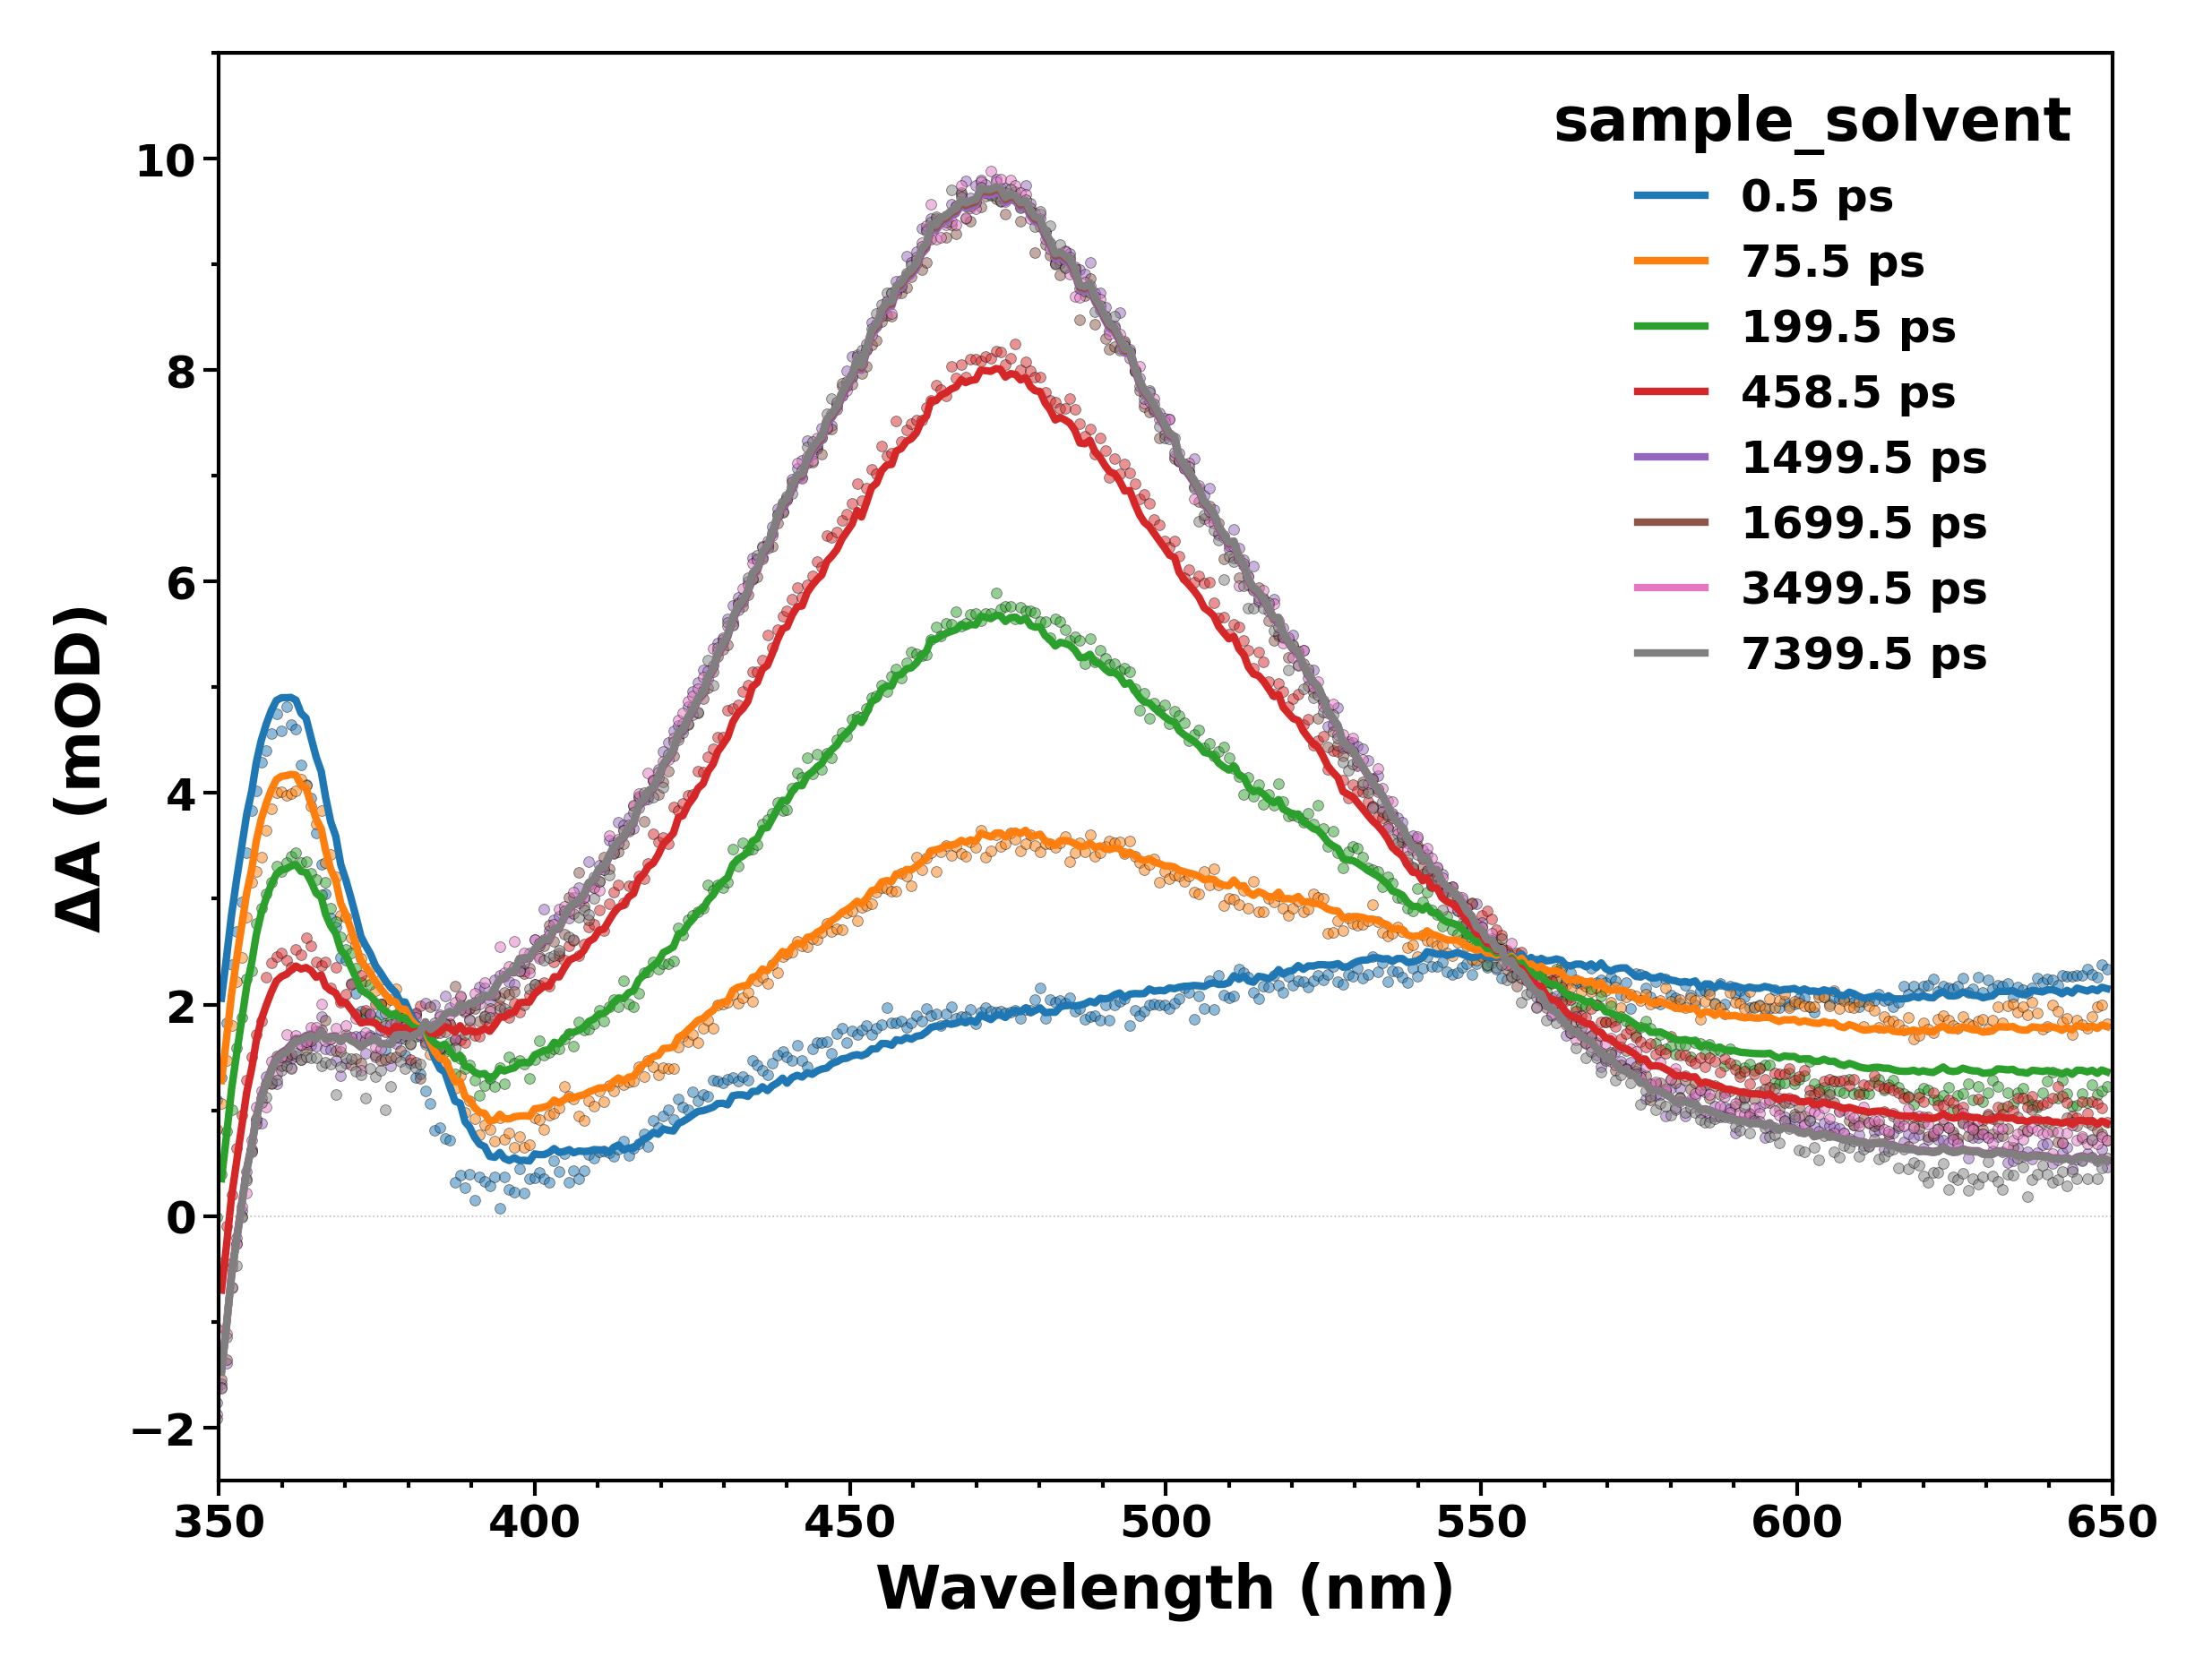

In [33]:
reload(mp)

fp_spectra = glob.glob(f"*_fsta_spectra.csv")
df_spectra = pd.read_csv(fp_spectra[0], header=0, index_col=0, sep=",")
fp_fitted_spectra = glob.glob(f"{folder_fitting_results}/*_fitted_fsta_spectra.csv")
df_fitted_spectra = pd.read_csv(fp_fitted_spectra[0], header=0, index_col=0, sep=",")
fig_fitted_spectra = mp.display_fsta_fitted_spectra_bnm(
    list_df=[df_spectra, df_fitted_spectra],
    xlimit=nm_limit,
    ylimit=[[-2.5, 11], 2, 1],
    legendtitle=sample,
    # legendposition="upper left",
)
plt.show()
fig_fitted_spectra.savefig(f"{path}/{sample}_{path}_fitted_fsta_spectra.svg")

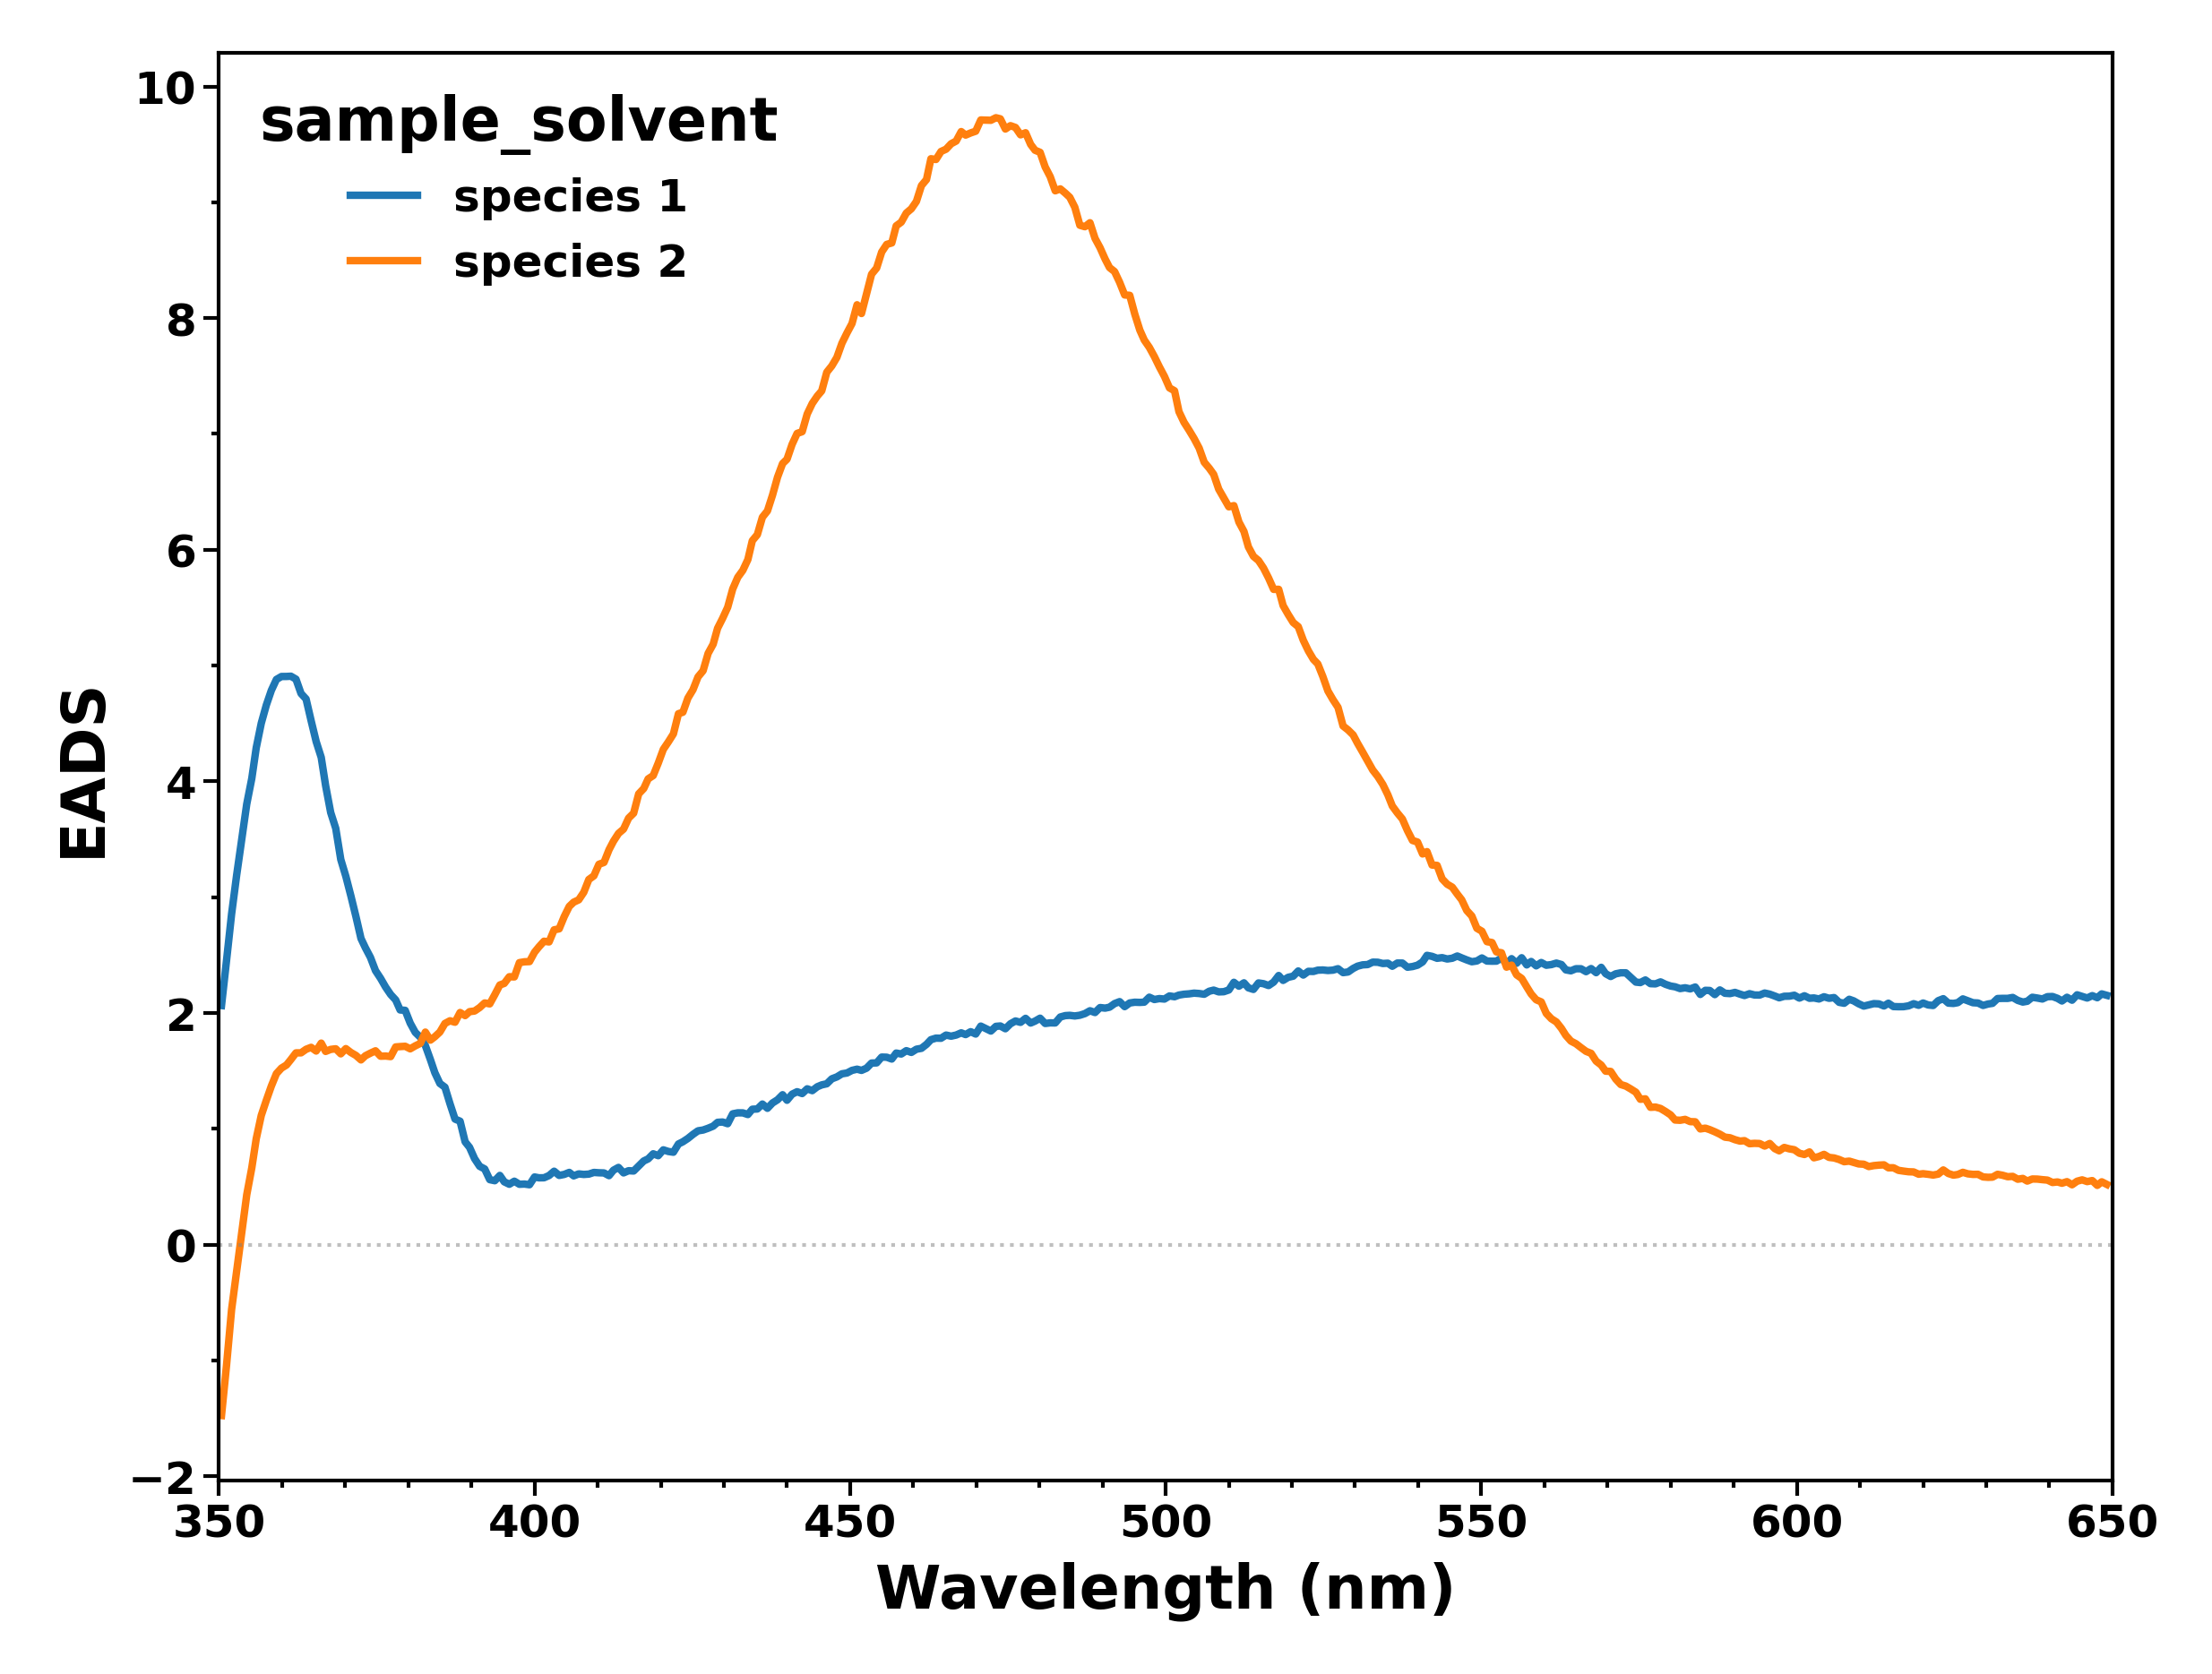

In [34]:
fp_fitted_das = glob.glob(f"{folder_fitting_results}/*_fitted_fsta_das.csv")
df_fitted_das = pd.read_csv(fp_fitted_das[0], header=0, index_col=0, sep=",")
fig_fitted_das = mp.display_fsta_globalfit_das_bnm(
    df_das_wl=df_fitted_das,
    xlimit=nm_limit,
    # ylimit=od_limit,
    ylabel="EADS",
    legendtitle=sample,
    # legendtext=[
    #     f"A k\u2081\u207b\u00b9 = {tau1}",
    #     f"B k\u2082\u207b\u00b9 = {tau2}",
    # ],
    legendposition="upper left",
)
plt.show()
fig_fitted_das.savefig(f"{path}/{sample}_{path}_fitted_fsta_das.svg")

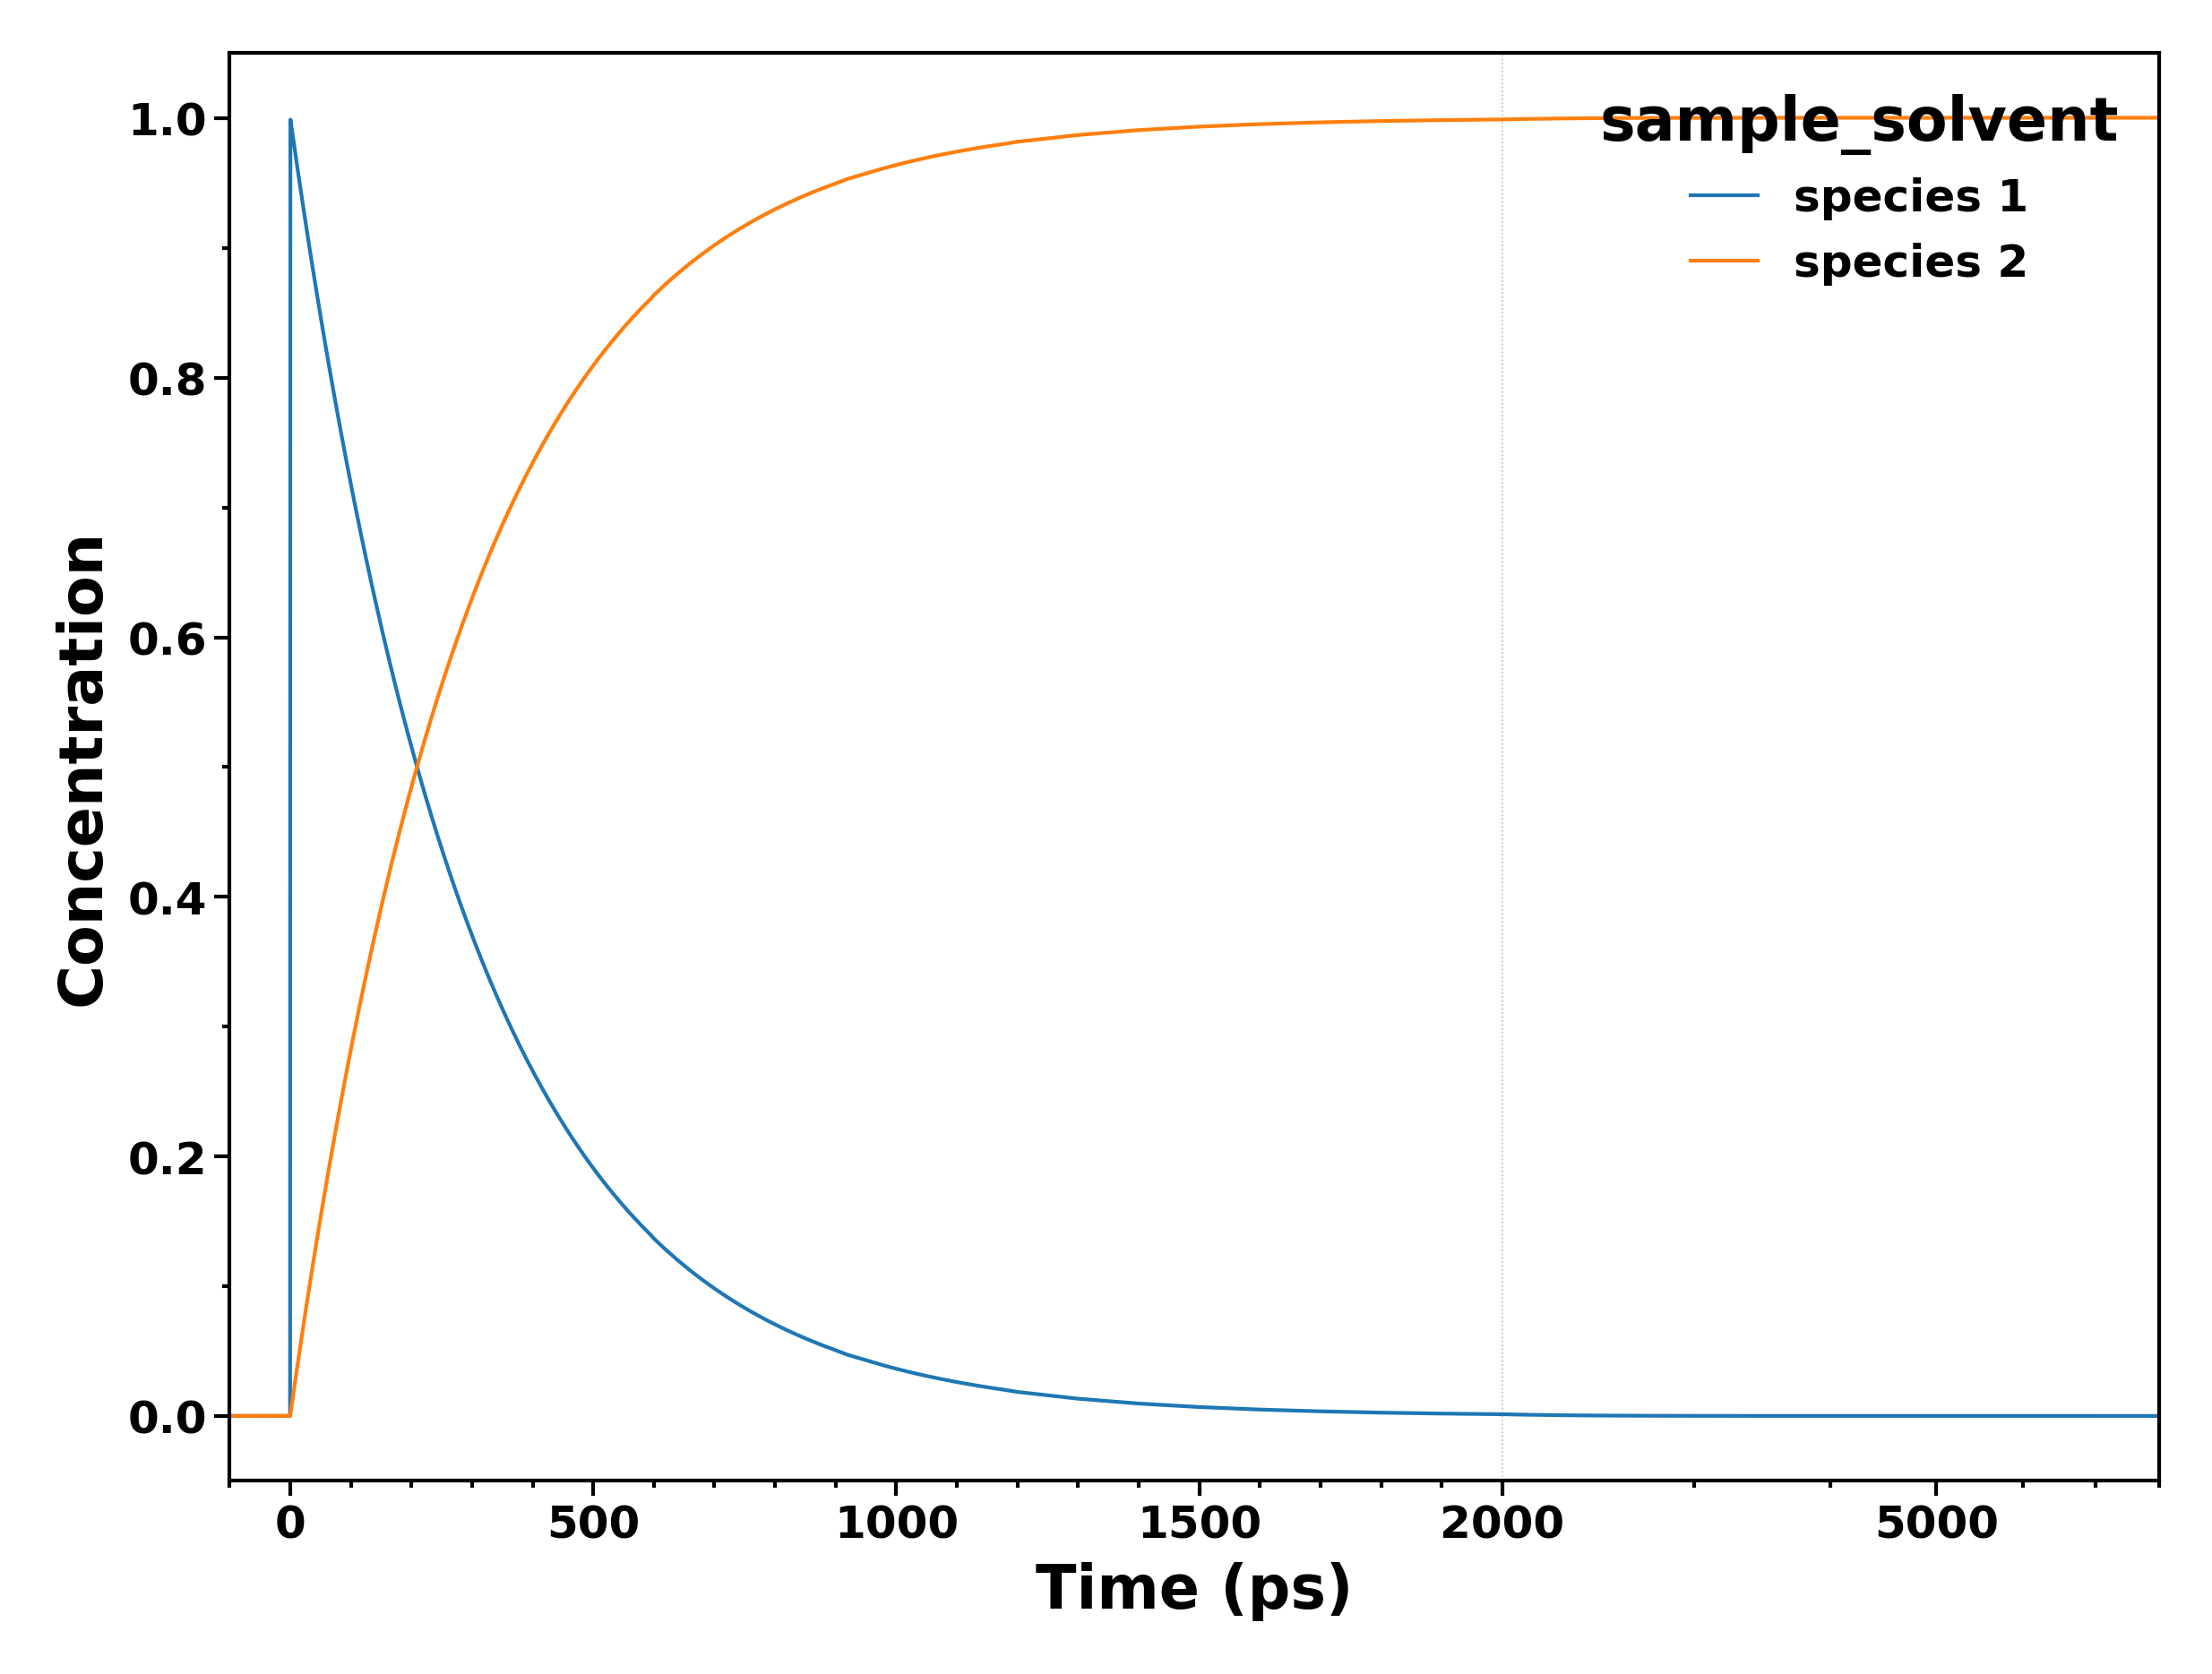

In [35]:
fp_fitted_conc = glob.glob(f"{folder_fitting_results}/*_fitted_fsta_conc.csv")
df_fitted_conc = pd.read_csv(fp_fitted_conc[0], header=0, index_col=0, sep=",")
fig_fitted_conc = mp.display_fsta_globalfit_conc_symlog(
    df_1col=df_fitted_conc,
    xlimit=kinetics_t_limit,
    # ylimit=od_limit,
    legendtitle=sample,
    # legendtext=["A", "B", "C"],
    # legendtext=["S\u2081", "T\u2081"],
)
plt.show()
fig_fitted_conc.savefig(f"{path}/{sample}_{path}_fitted_fsta_conc.svg")